# CMAQ paper workbook

In [2]:
import os
import gc
import warnings
os.chdir('/workdir')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["SM_FRAMEWORK"] = "tf.keras"

from collections import OrderedDict
warnings.filterwarnings('ignore', category=UserWarning)

import netCDF4 as nc
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import sem
import shap
import joblib

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import backend

from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def ioa_score(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)
def nmae_score(y_true, y_pred):
    return np.mean(np.abs(y_true + 1e-7 - y_pred) / np.abs(y_true + 1e-7))

## Load datasets

In [2]:
SEASON = ['January', 'April', 'July', 'October']
CTRL_KEY_LIST = ['ALL_POW','ALL_IND','ALL_MOB','ALL_RES','NH3_AGR','ALL_SLV','ALL_OTH']
EMIS_KEY = ['SO2', 'NH3', 'VOCs', 'CO', 'PM2_5', 'NOx']
CONC_KEY = ['PM2.5_SO4', 'PM2.5_NH4', 'PM2.5_NO3', 'PM2.5_Total']#, 'O3']
REGION_CODE = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'
}
REGION_GROUP = {
    'A': 'MR', 'B': 'MR', 'F': 'MR', # Metropolitan Region
    'H': 'CR', 'I': 'CR', 'O': 'CR', 'Q': 'CR', # Chungcheong Region
    'C': 'YR', 'D': 'YR', 'J': 'YR', 'K': 'YR', 'P': 'YR', # Yeongnam Region
    'E': 'JR', 'L': 'JR', 'M': 'JR', # Jeolla Region
    'G': 'GR', # Gangwon Region
    'N': 'JJR', # Jeju Region
}

FEATURE_LBL = []
for name in REGION_CODE.values():
    for key in CTRL_KEY_LIST:
        FEATURE_LBL.append(f"{name} {key}")

In [9]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=100, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ioa = ioa_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    nmae = nmae_score(y_true, y_pred)
    # add text
    ax.text(
        0.05, 0.90, f"$R^2={r2:.4f}$ \nIOA={ioa:.4f}\nMSE={rmse:.4f}\nNMAE={nmae:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=10
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

def read_cdf_map_data(
        data_path:str,
        target:str,
        prefix:str,
        keys:list[str]) -> np.ndarray:
    paths = [os.path.join(f'{data_path}/{target}/', f'{prefix}.{i+1}') for i in range(119)]
    datasets = [[nc.Dataset(path, 'r')[key][0, 0].data.tolist() for key in keys] for path in paths]
    return np.transpose(datasets, (0, 2, 3, 1))

def read_ctrl_matrix(data_path:str) -> np.ndarray:
    path = f'{data_path}/control_matrix.csv'
    return pd.read_csv(path, index_col=0).values

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/workdir/datasets/geoinfo/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'
}

ctprvn = get_ctprvn_map()
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
ctprvn_proj = ctprvn.to_crs(proj)

grid_alloc = pd.read_csv('/workdir/datasets/grid_allocation.csv')
grid_alloc = grid_alloc.sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False])
grid_alloc = grid_alloc.drop_duplicates(subset=['Row', 'Column'], keep='first').reset_index(drop=True)

grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], REGION_CODE[atob[idx]]
        ])
    # total_index += idx
# total_index = [list(index) for index in total_index]
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1
row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)

In [10]:
grid_alloc

Column  Row Region_Code
0         29   59           A
1         28   59           A
2         27   58           A
3         27   59           A
4         28   58           A
...      ...  ...         ...
1683      31   48           Q
1684      31   47           Q
1685      31   46           Q
1686      30   48           Q
1687      30   47           Q

[1688 rows x 3 columns]

In [11]:
grid = grid_alloc.values.tolist()
with open('/workdir/cmaqnet/alloc_.py', 'w') as f:
    for i, (col, row, region_code) in enumerate(grid):
        if i%10==9:
            f.write(f"['','{region_code}',{row:2d},{col:2d},100.0],\n")
        else:
            f.write(f"['','{region_code}',{row:2d},{col:2d},100.0],")

In [10]:
CTRL_KEY_LIST = ['ALL_POW','ALL_IND','ALL_MOB','ALL_RES','NH3_AGR','ALL_SLV','ALL_OTH']
# EMIS_KEY = ['SO2', 'NH3', 'VOCs', 'CO', 'PM2_5', 'NOx']
EMIS_KEY_LIST = ['SO2', 'PM2_5', 'NOx', 'VOCs', 'NH3', 'CO']
EMIS_UNIT_LIST = ['moles/s', 'g/s', 'moles/s', 'moles/s', 'moles/s', 'moles/s']
CONC_KEY_LIST = ['PM2_5']
ctrl_mat = read_ctrl_matrix('/workdir/datasets')
ctrl_map = np.zeros((ctrl_mat.shape[0], 82, 67, 7))
ctrl_map[:, :, :, 6] = 1.0
for i, key in enumerate(REGION_CODE.keys()):
    index = grid_alloc.loc[grid_alloc.Region_Code==key, ['Row', 'Column']].values
    row, col = zip(*index)
    ctrl_map[:, row, col, :] = ctrl_mat.reshape(-1, 17, 7)[:, i:i+1, :]

emis_yearly_map = read_cdf_map_data('/workdir/datasets', 'emission', 'EMIS_AVG', EMIS_KEY_LIST)
conc_yearly_map = read_cdf_map_data('/workdir/datasets', 'concentration', 'ACONC', CONC_KEY_LIST)

ctrl_train, ctrl_test, ctrl_map_train, ctrl_map_test, emis_train, emis_test, conc_train, conc_test = \
    train_test_split(ctrl_mat, ctrl_map, emis_yearly_map, conc_yearly_map, train_size=100, random_state=42)

In [5]:
ctrl_mat = read_ctrl_matrix('/workdir/datasets').reshape(-1, 17, 7)

index = 0
grid_a = grid_alloc.loc[grid_alloc.Region_Code=='A', ['Row', 'Column']].values
ratio_emis_map = (emis_yearly_map+1e-5) / (emis_yearly_map[0:1]+1e-5)
sample_grid = ratio_emis_map[:, grid_a[:, 0], grid_a[:, 1], :]
sample_ctrl = ctrl_map[:, grid_a[:, 0], grid_a[:, 1], :]

sample_grid.shape, sample_ctrl.shape

((119, 10, 6), (119, 10, 7))

In [ ]:
index = 0

np.cov(sample_grid)
# (np.corrcoef(sample_grid.transpose(0, 2, 1).reshape(-1, 10).T) @ sample_ctrl[index])

## Emission

In [8]:
weights = [120, 1, 120, 240, 60, 60]

### UNet

In [15]:
def get_unet_model(
    input_shape:tuple=(82, 67, 7),
    classes:int=1,
    hidden_size:tuple=(128, 96),
    in_filters:int=20,
    kernel:int=12,
    activation:str='silu',
    dropout:float=0.0) -> tf.keras.Model:
    def encoder_block(x_map, t_emb=None, filters:int=1, kernel:int=3, dropout:float=0.0):
        x_map = tf.keras.layers.Conv2D(filters, kernel, padding='same')(x_map)
        x_map = tf.keras.layers.BatchNormalization()(x_map)
        x_map = tf.keras.layers.Activation(activation)(x_map)
        x_param = None
        if t_emb is not None:
            t_emb = tf.keras.layers.Dense(filters)(t_emb)
            t_emb = tf.keras.layers.Activation(activation)(t_emb)
            t_emb = tf.keras.layers.Reshape((1, 1, filters))(t_emb)
            x_param = tf.keras.layers.Multiply()([x_map, t_emb])
        x_out = tf.keras.layers.Conv2D(filters, kernel, padding='same')(x_map)
        if x_param is not None:
            x_out = tf.keras.layers.Add()([x_out, x_param])
        x_out = tf.keras.layers.BatchNormalization()(x_out)
        x_out = tf.keras.layers.Activation(activation)(x_out)
        x_out = tf.keras.layers.Dropout(dropout)(x_out)
        return x_out
    
    def decoder_block(x0, x1, filters:int=1, kernel:int=3, dropout:float=0.0, t_emb=None):
        x0 = tf.keras.layers.Conv2DTranspose(
            filters, kernel, strides=2, padding='same')(x0)
        x0 = tf.keras.layers.BatchNormalization()(x0)
        x0 = tf.keras.layers.Activation(activation)(x0)
        x_param = None
        if t_emb is not None:
            t_emb = tf.keras.layers.Dense(filters)(t_emb)
            t_emb = tf.keras.layers.Activation(activation)(t_emb)
            t_emb = tf.keras.layers.Reshape((1, 1, filters))(t_emb)
            x_param = tf.keras.layers.Multiply()([x0, t_emb])
        x0 = tf.keras.layers.Concatenate()([x0, x1])
        x0 = tf.keras.layers.Conv2D(filters, kernel, padding='same')(x0)
        if x_param is not None:
            x0 = tf.keras.layers.Add()([x0, x_param])
        x0 = tf.keras.layers.BatchNormalization()(x0)
        x0 = tf.keras.layers.Activation(activation)(x0)
        x0 = tf.keras.layers.Dropout(dropout)(x0)
        return x0
    
    inputs = tf.keras.Input(shape=input_shape)
    init_map = tf.keras.layers.Resizing(*hidden_size)(inputs)

    # t_emb = tf.keras.layers.Dense(128)(inputs)
    # t_emb = tf.keras.layers.BatchNormalization()(t_emb)
    # t_emb = tf.keras.layers.Activation(activation)(t_emb)
    t_emb = None
    
    x = x0 = encoder_block(init_map, t_emb, in_filters, kernel, dropout)
    x = tf.keras.layers.MaxPool2D()(x)
    x = x1 = encoder_block(x, t_emb, in_filters*2, kernel, dropout)
    x = tf.keras.layers.MaxPool2D()(x)
    x = x2 = encoder_block(x, t_emb, in_filters*4, kernel, dropout)
    x = tf.keras.layers.MaxPool2D()(x)
    x = x3 = encoder_block(x, t_emb, in_filters*8, kernel, dropout)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = encoder_block(x, t_emb, in_filters*16, kernel, dropout)
    x = decoder_block(x, x3, in_filters*8, kernel, dropout)
    x = decoder_block(x, x2, in_filters*4, kernel, dropout)
    x = decoder_block(x, x1, in_filters*2, kernel, dropout)
    x = decoder_block(x, x0, in_filters, kernel, dropout)
    
    x = tf.keras.layers.Resizing(82, 67)(x)
    x = tf.keras.layers.Conv2D(classes, 1)(x)
    x = tf.abs(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# emis_yearly_unet_model = get_unet_model(
#     input_shape=(82, 67, 7),
#     classes=6
# )

emis_yearly_unet_model = OrderedDict({
    key: get_unet_model(
        input_shape=(82, 67, 7),
        classes=1,
        kernel=9
    )
    for i, key in enumerate(EMIS_KEY_LIST)
})


# history = emis_yearly_unet_model.fit(
#     ctrl_map_train, emis_train,
#     validation_data=(ctrl_test, emis_test),
#     batch_size=16, epochs=1000, verbose=1
# )

# emis_yearly_unet_pred = emis_yearly_unet_model.predict(ctrl_test)

In [16]:
for i, model in enumerate(emis_yearly_unet_model.values()):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),)
    model.fit(
        ctrl_map_train, emis_train[:, :, :, i],
        validation_split=0.1, batch_size=16, epochs=1200, verbose=1
    )
# emis_yearly_unet_model.fit(
#     ctrl_map_train, emis_train,
#     validation_split=0.1, batch_size=32, epochs=1000, verbose=1
# )

Epoch 1/1200
6/6 [==============================] - 14s 566ms/step - loss: 0.5967 - val_loss: 2371.2639
Epoch 2/1200
6/6 [==============================] - 0s 62ms/step - loss: 0.0276 - val_loss: 554309.5625
Epoch 3/1200
6/6 [==============================] - 0s 63ms/step - loss: 0.0181 - val_loss: 451224.7500
Epoch 4/1200
6/6 [==============================] - 0s 61ms/step - loss: 0.0161 - val_loss: 719146.6875
Epoch 5/1200
6/6 [==============================] - 0s 60ms/step - loss: 0.0156 - val_loss: 161238.5625
Epoch 6/1200
6/6 [==============================] - 0s 60ms/step - loss: 0.0149 - val_loss: 23157.8535
Epoch 7/1200
6/6 [==============================] - 0s 62ms/step - loss: 0.0148 - val_loss: 5958.8428
Epoch 8/1200
6/6 [==============================] - 0s 63ms/step - loss: 0.0146 - val_loss: 2164.2129
Epoch 9/1200
6/6 [==============================] - 0s 61ms/step - loss: 0.0144 - val_loss: 681.8489
Epoch 10/1200
6/6 [==============================] - 0s 62ms/step - loss

In [17]:
for i, model in enumerate(emis_yearly_unet_model.values()):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.MeanSquaredError(),)
    model.fit(
        ctrl_map_train, emis_train[:, :, :, i],
        validation_split=0.1, batch_size=16, epochs=1200, verbose=1
    )

Epoch 1/1200
6/6 [==============================] - 9s 144ms/step - loss: 2.9470e-05 - val_loss: 1.0426e-04
Epoch 2/1200
6/6 [==============================] - 0s 62ms/step - loss: 2.2481e-05 - val_loss: 9.4982e-05
Epoch 3/1200
6/6 [==============================] - 0s 62ms/step - loss: 1.8611e-05 - val_loss: 9.3126e-05
Epoch 4/1200
6/6 [==============================] - 0s 65ms/step - loss: 1.5803e-05 - val_loss: 9.0774e-05
Epoch 5/1200
6/6 [==============================] - 0s 63ms/step - loss: 1.2650e-05 - val_loss: 9.0689e-05
Epoch 6/1200
6/6 [==============================] - 0s 60ms/step - loss: 1.3293e-05 - val_loss: 8.9967e-05
Epoch 7/1200
6/6 [==============================] - 0s 59ms/step - loss: 1.4483e-05 - val_loss: 1.0352e-04
Epoch 8/1200
6/6 [==============================] - 0s 63ms/step - loss: 1.3709e-05 - val_loss: 1.0185e-04
Epoch 9/1200
6/6 [==============================] - 0s 62ms/step - loss: 1.4078e-05 - val_loss: 9.4590e-05
Epoch 10/1200
6/6 [=================

In [18]:
for i, model in enumerate(emis_yearly_unet_model.values()):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.MeanSquaredError(),)
    model.fit(
        ctrl_map_train, emis_train[:, :, :, i],
        validation_split=0.1, batch_size=16, epochs=1200, verbose=1
    )

Epoch 1/1200
6/6 [==============================] - 8s 134ms/step - loss: 2.4127e-06 - val_loss: 8.4641e-05
Epoch 2/1200
6/6 [==============================] - 0s 62ms/step - loss: 2.6091e-06 - val_loss: 8.4504e-05
Epoch 3/1200
6/6 [==============================] - 0s 62ms/step - loss: 2.8383e-06 - val_loss: 8.3904e-05
Epoch 4/1200
6/6 [==============================] - 0s 62ms/step - loss: 2.6195e-06 - val_loss: 8.3773e-05
Epoch 5/1200
6/6 [==============================] - 0s 62ms/step - loss: 2.9027e-06 - val_loss: 8.3565e-05
Epoch 6/1200
6/6 [==============================] - 0s 62ms/step - loss: 2.5576e-06 - val_loss: 8.3482e-05
Epoch 7/1200
6/6 [==============================] - 0s 63ms/step - loss: 2.2791e-06 - val_loss: 8.4358e-05
Epoch 8/1200
6/6 [==============================] - 0s 60ms/step - loss: 2.2924e-06 - val_loss: 8.4015e-05
Epoch 9/1200
6/6 [==============================] - 0s 62ms/step - loss: 2.3024e-06 - val_loss: 8.4046e-05
Epoch 10/1200
6/6 [=================

In [19]:
inputs = tf.keras.Input(shape=(82, 67, 7))
outputs = [model(inputs) for model in emis_yearly_unet_model.values()]
outputs = tf.keras.layers.Concatenate()(outputs)
emis_yearly_unet_model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)
emis_yearly_unet_model_0.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss=tf.keras.losses.MeanSquaredError(),)

In [21]:
emis_yearly_unet_pred = emis_yearly_unet_model_0.predict(ctrl_map_test)

1/1 [==============================] - 4s 4s/step


#### Evaluation

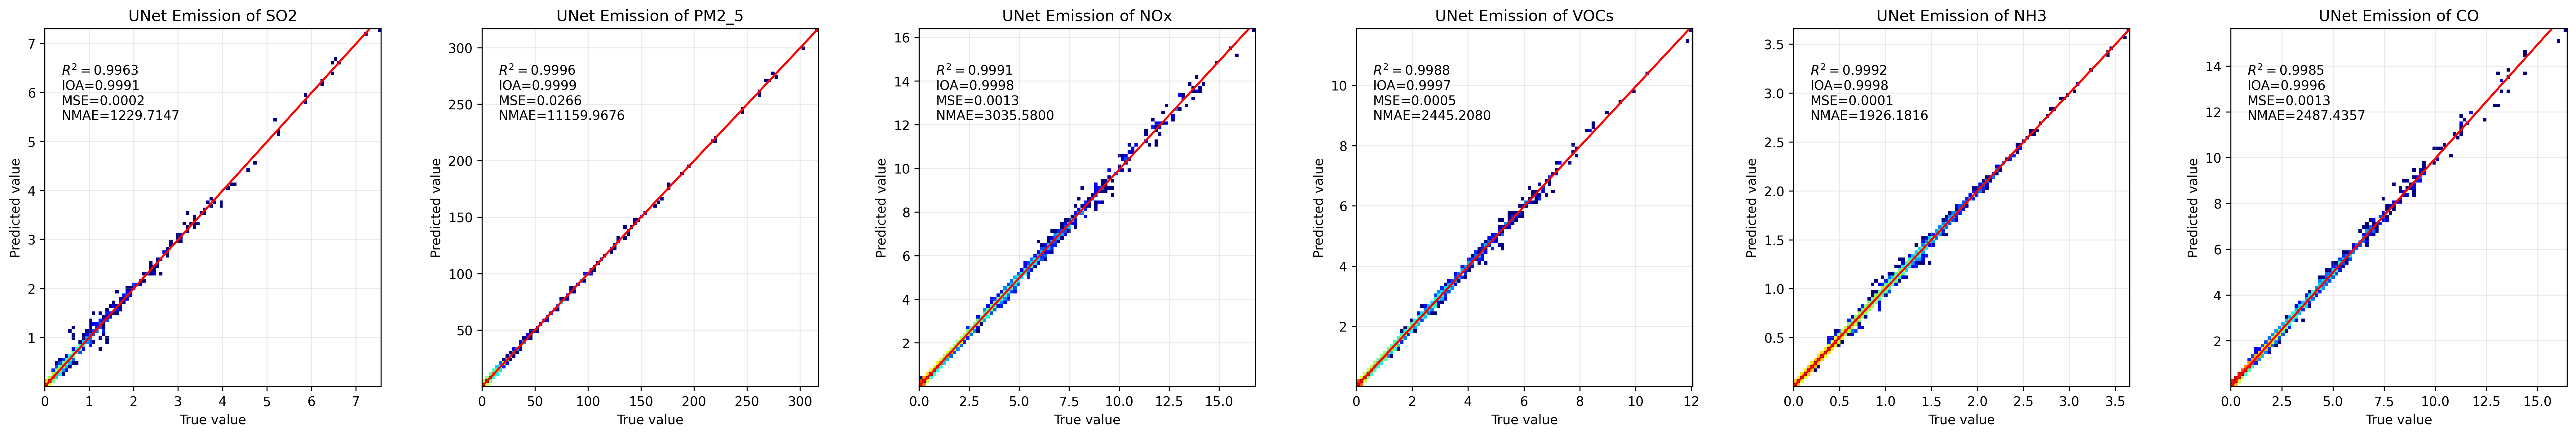

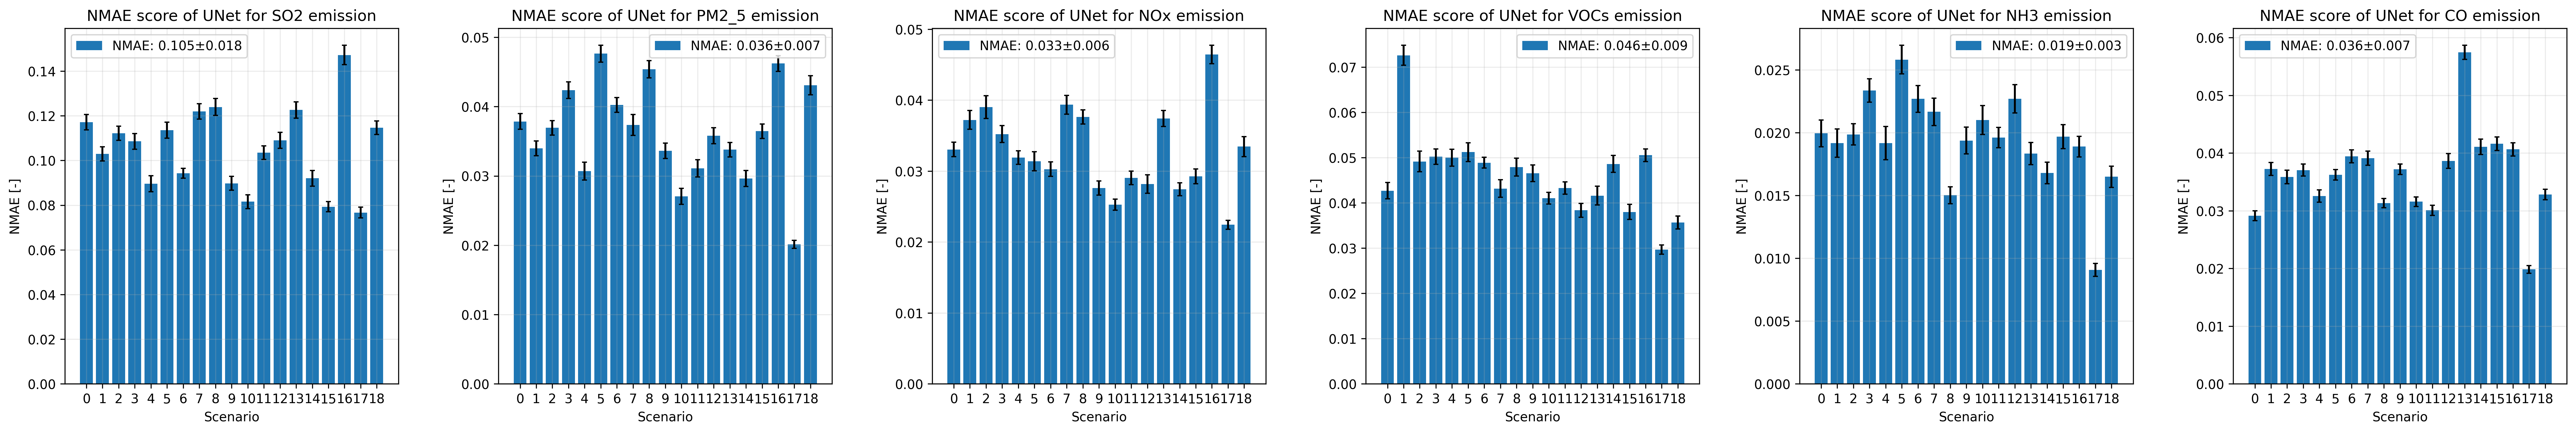

In [22]:
fig, axes = plt.subplots(1, 6, figsize=(35, 5), dpi=300)

for idx in range(6):
    y_true = emis_test[:, row_indices, col_indices, idx].reshape(-1)
    y_pred = emis_yearly_unet_pred[:, row_indices, col_indices, idx].reshape(-1)
    axes[idx] = plot_scatter(axes[idx], y_true, y_pred)
    axes[idx].grid(alpha=0.25)
    axes[idx].set_title(f"UNet Emission of {EMIS_KEY_LIST[idx]}")
    axes[idx].set_xlabel("True value")
    axes[idx].set_ylabel("Predicted value")

plt.subplots_adjust(wspace=0.3)
plt.show()

fig, axes = plt.subplots(1, 6, figsize=(35, 5), dpi=300)

for idx in range(6):
    y_true = emis_test[:, row_indices, col_indices, idx].reshape(19, -1)
    y_pred = emis_yearly_unet_pred[:, row_indices, col_indices, idx].reshape(19, -1)
    score, score_std = get_score(y_true, y_pred)
    label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'
    axes[idx].bar(np.arange(19), score, yerr=score_std, label=label_text, capsize=2)
    axes[idx].set_xticks(np.arange(19), range(19))
    axes[idx].legend()
    axes[idx].grid(alpha=0.25)
    axes[idx].set_title(f"NMAE score of UNet for {EMIS_KEY_LIST[idx]} emission")
    axes[idx].set_xlabel('Scenario')
    axes[idx].set_ylabel('NMAE [-]')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [23]:
emis_yearly_unet_model_0.save(f'/workdir/paper/models/conc_unet_model_yearly/emis_unet/')

INFO:tensorflow:Assets written to: /workdir/paper/models/conc_unet_model_yearly/emis_unet/assets


INFO:tensorflow:Assets written to: /workdir/paper/models/conc_unet_model_yearly/emis_unet/assets


In [5]:
emis_yearly_unet_model_0 = tf.keras.models.load_model(f'/workdir/paper/models/conc_unet_model_yearly/emis_unet/')

### Total Evaluation

In [24]:
continuous_sample = np.array([[i for _ in range(119)] for i in np.arange(0, 2.01, 0.01)])
continuous_sample.shape

(201, 119)

In [25]:
def get_ctrl_map(X):
    X = X.reshape(-1, 17, 7)
    ctrl_map = np.zeros((X.shape[0], 82, 67, 7))
    for i, key in enumerate(REGION_CODE.keys()):
        index = grid_alloc.loc[grid_alloc.Region_Code==key, ['Row', 'Column']]
        index = index.drop_duplicates().values - 1
        row, col = zip(*index)
        ctrl_map[:, row, col, :] = X[:, i:i+1, :]
    return ctrl_map

emis_yearly_unet_continuous = emis_yearly_unet_model_0.predict(get_ctrl_map(continuous_sample))
emis_yearly_unet_continuous.shape

7/7 [==============================] - 3s 328ms/step


(201, 82, 67, 6)

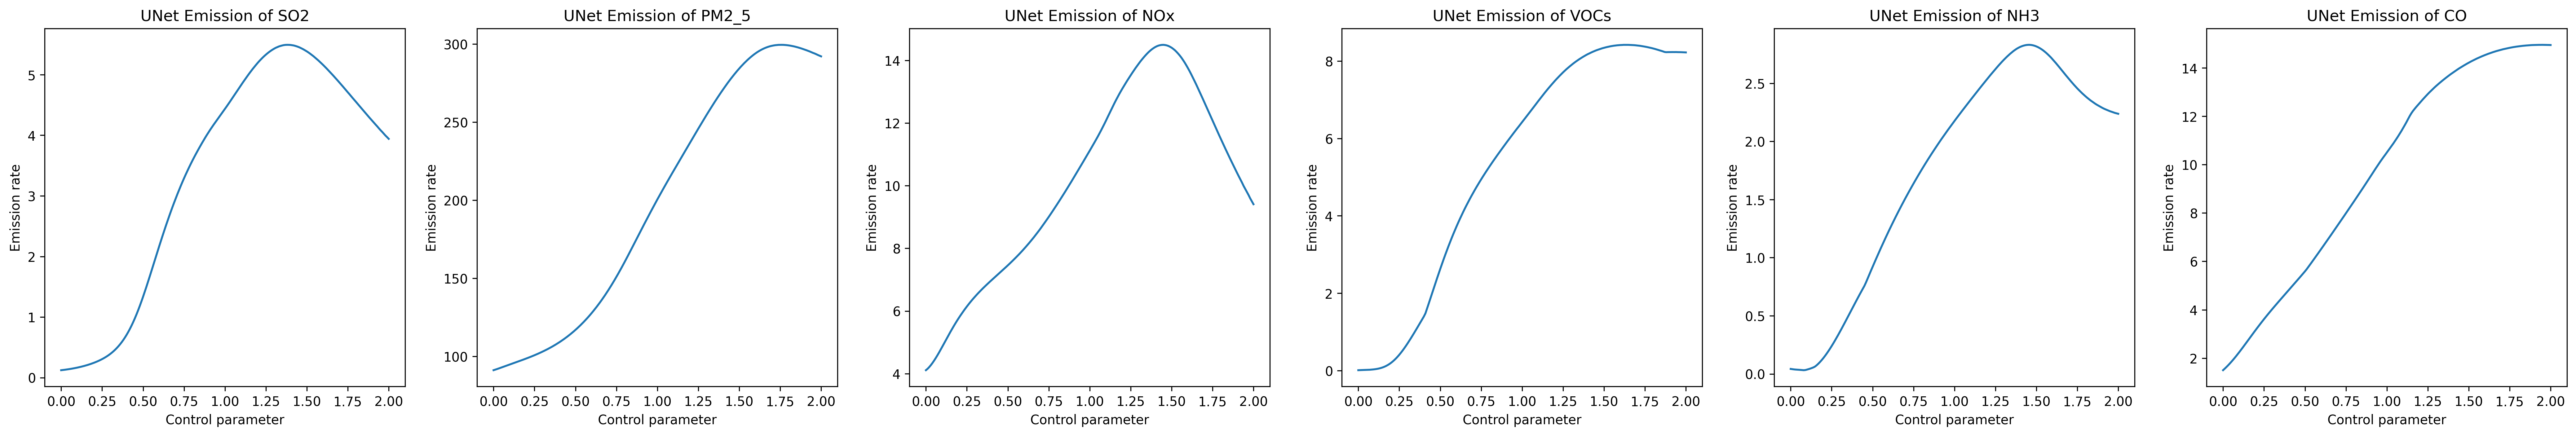

In [26]:
emis_yearly_unet_continuous = emis_yearly_unet_continuous.max(axis=(1, 2))

fig, axes = plt.subplots(1, 6, figsize=(35, 5), dpi=300)
for i in range(6):
    axes[i].plot(np.arange(0, 2.01, 0.01), emis_yearly_unet_continuous[:, i])
    axes[i].set_title(f"UNet Emission of {EMIS_KEY_LIST[i]}")
    axes[i].set_xlabel("Control parameter")
    axes[i].set_ylabel("Emission rate")
plt.show()

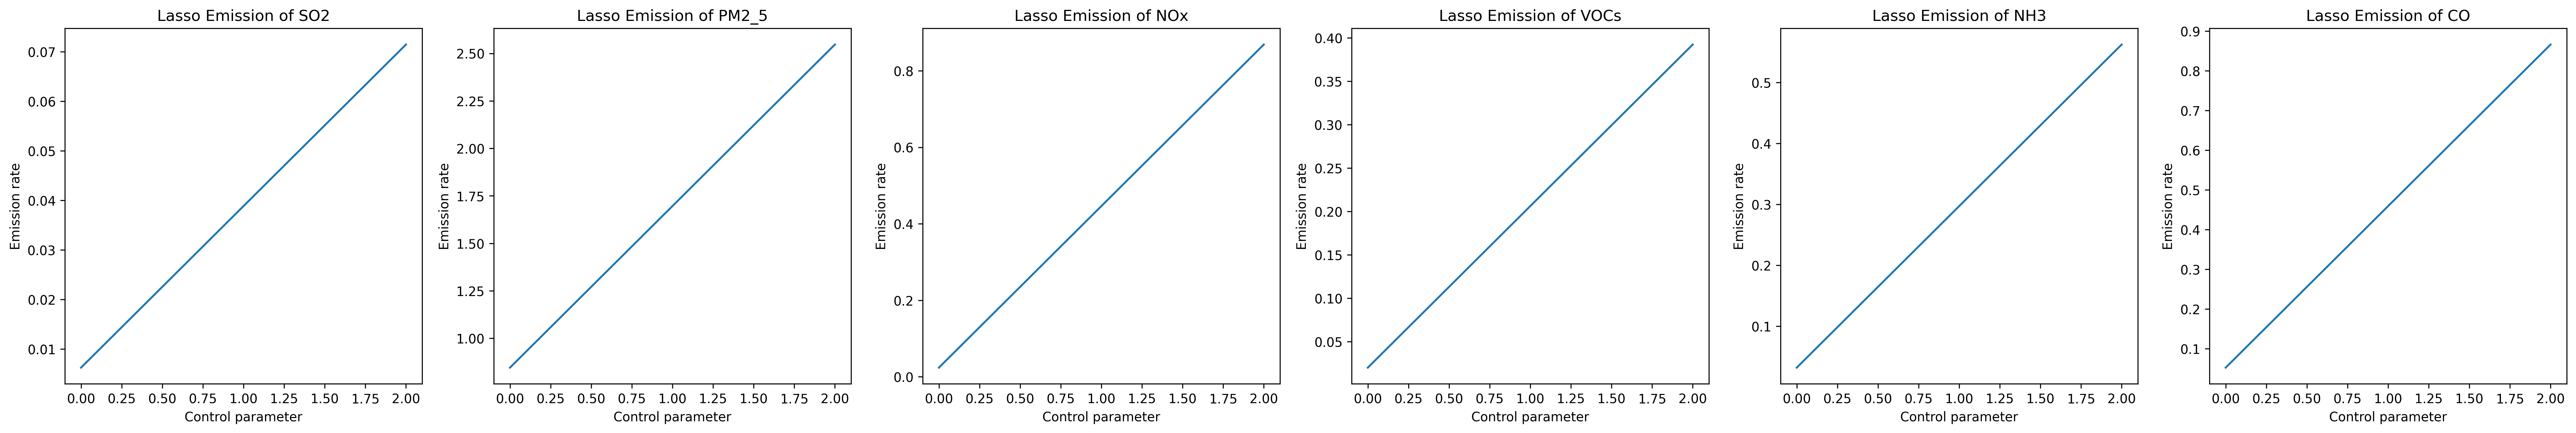

In [58]:
emis_yearly_lasso_contiuous = np.array([
    emis_yearly_lasso_model[key].predict(continuous_sample)/weights[i]
    for i, key in enumerate(EMIS_KEY_LIST)
])
emis_yearly_lasso_contiuous = emis_yearly_lasso_contiuous.mean(axis=-1)

fig, axes = plt.subplots(1, 6, figsize=(35, 5), dpi=300)
for i in range(6):
    axes[i].plot(np.arange(0, 2.01, 0.01), emis_yearly_lasso_contiuous[i])
    axes[i].set_title(f"Lasso Emission of {EMIS_KEY_LIST[i]}")
    axes[i].set_xlabel("Control parameter")
    axes[i].set_ylabel("Emission rate")
plt.show()

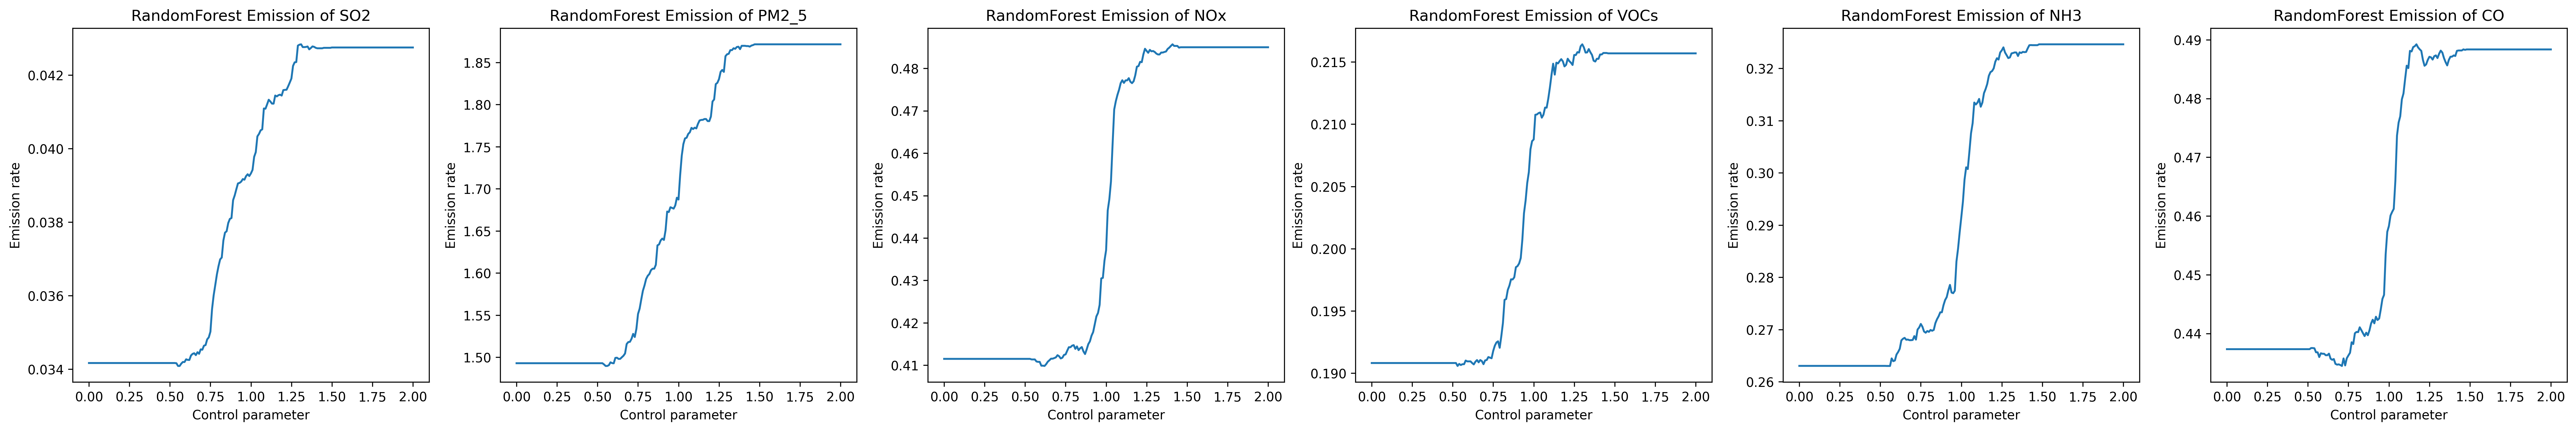

In [59]:
emis_yearly_rf_contiuous = np.array([
    emis_yearly_rf_model[key].predict(continuous_sample)/weights[i]
    for i, key in enumerate(EMIS_KEY_LIST)
])
emis_yearly_rf_contiuous = emis_yearly_rf_contiuous.mean(axis=-1)

fig, axes = plt.subplots(1, 6, figsize=(35, 5), dpi=300)
for i in range(6):
    axes[i].plot(np.arange(0, 2.01, 0.01), emis_yearly_rf_contiuous[i])
    axes[i].set_title(f"RandomForest Emission of {EMIS_KEY_LIST[i]}")
    axes[i].set_xlabel("Control parameter")
    axes[i].set_ylabel("Emission rate")
plt.show()

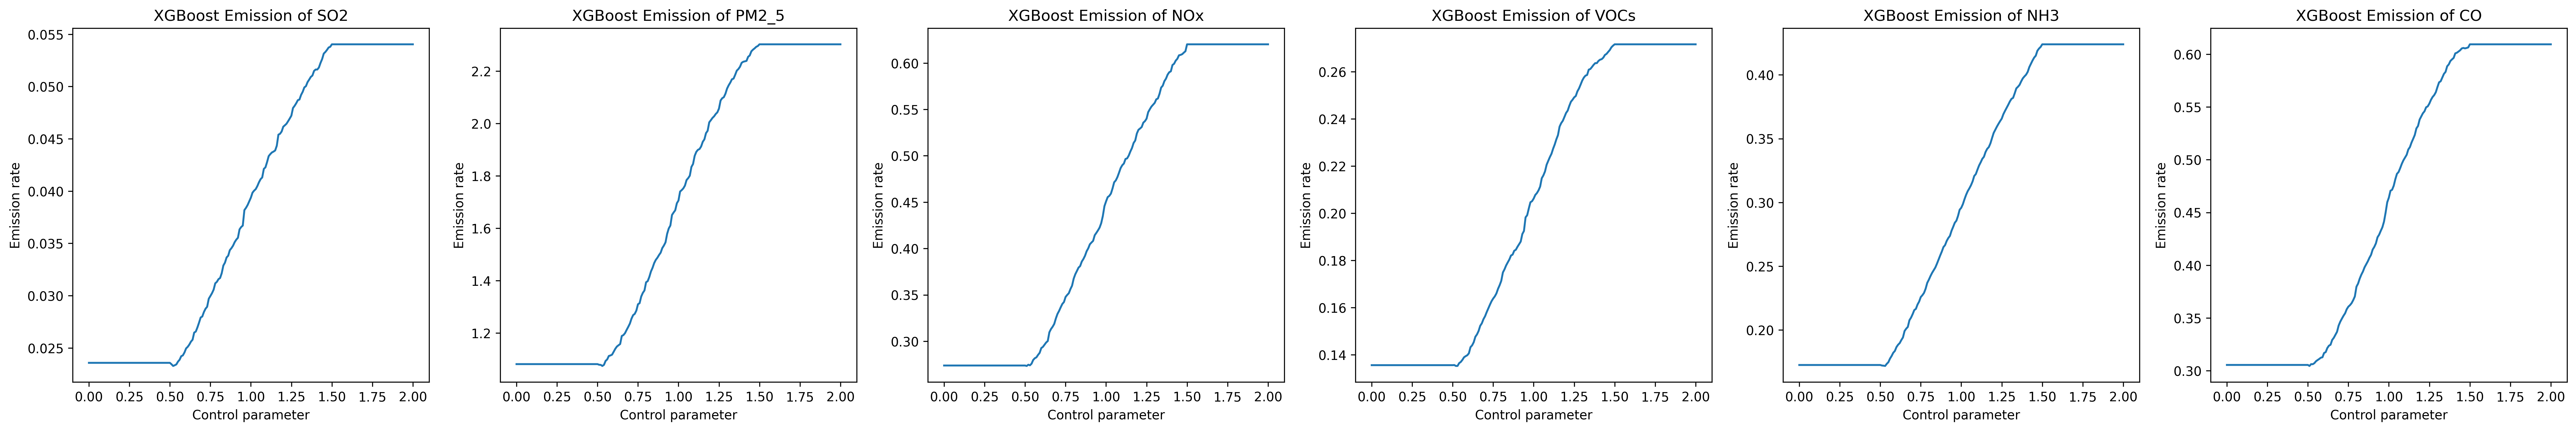

In [60]:
emis_yearly_xgb_contiuous = np.array([
    emis_yearly_xgb_model[key].predict(continuous_sample)/weights[i]
    for i, key in enumerate(EMIS_KEY_LIST)
])
emis_yearly_xgb_contiuous = emis_yearly_xgb_contiuous.mean(axis=-1)

fig, axes = plt.subplots(1, 6, figsize=(35, 5), dpi=300)
for i in range(6):
    axes[i].plot(np.arange(0, 2.01, 0.01), emis_yearly_xgb_contiuous[i])
    axes[i].set_title(f"XGBoost Emission of {EMIS_KEY_LIST[i]}")
    axes[i].set_xlabel("Control parameter")
    axes[i].set_ylabel("Emission rate")
plt.show()

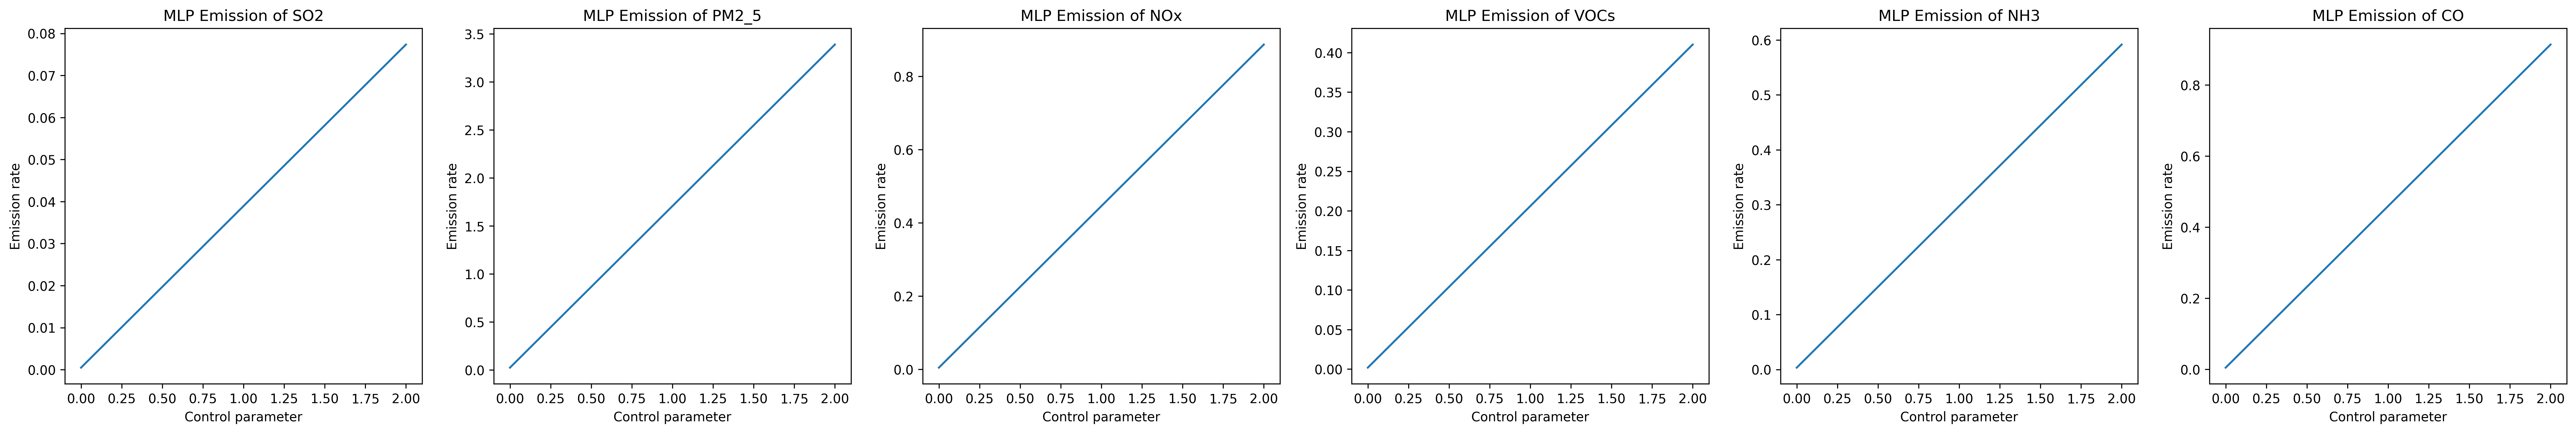

In [61]:
emis_yearly_mlp_contiuous = np.array([
    emis_yearly_mlp_model[key].predict(continuous_sample)/weights[i]
    for i, key in enumerate(EMIS_KEY_LIST)
])
emis_yearly_mlp_contiuous = emis_yearly_mlp_contiuous.mean(axis=-1)

fig, axes = plt.subplots(1, 6, figsize=(35, 5), dpi=300)
for i in range(6):
    axes[i].plot(np.arange(0, 2.01, 0.01), emis_yearly_mlp_contiuous[i])
    axes[i].set_title(f"MLP Emission of {EMIS_KEY_LIST[i]}")
    axes[i].set_xlabel("Control parameter")
    axes[i].set_ylabel("Emission rate")
plt.show()

## Concentration

### UNet

In [ ]:
class CMAQNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
    
    def get_encoder(self):
        return
    
    def get_decoder(self):
        return

In [31]:
def get_unet_model(
    input_shape:tuple=(82, 67, 7),
    hidden_size:tuple=(128, 96),
    in_filters:int=20,
    kernel:int=12,
    activation:str='silu',
    dropout:float=0.0) -> tf.keras.Model:
    def encoder_block(x_map, t_emb=None, filters:int=1, kernel:int=3, dropout:float=0.0):
        x_map = tf.keras.layers.Conv2D(filters, kernel, padding='same')(x_map)
        x_map = tf.keras.layers.BatchNormalization()(x_map)
        x_map = tf.keras.layers.Activation(activation)(x_map)
        x_param = None
        if t_emb is not None:
            t_emb = tf.keras.layers.Dense(filters)(t_emb)
            t_emb = tf.keras.layers.Activation(activation)(t_emb)
            t_emb = tf.keras.layers.Reshape((1, 1, filters))(t_emb)
            x_param = tf.keras.layers.Multiply()([x_map, t_emb])
        x_out = tf.keras.layers.Conv2D(filters, kernel, padding='same')(x_map)
        if x_param is not None:
            x_out = tf.keras.layers.Add()([x_out, x_param])
        x_out = tf.keras.layers.BatchNormalization()(x_out)
        x_out = tf.keras.layers.Activation(activation)(x_out)
        x_out = tf.keras.layers.Dropout(dropout)(x_out)
        return x_out
    
    def decoder_block(x0, x1, filters:int=1, kernel:int=3, dropout:float=0.0, t_emb=None):
        x0 = tf.keras.layers.Conv2DTranspose(
            filters, kernel, strides=2, padding='same')(x0)
        x0 = tf.keras.layers.BatchNormalization()(x0)
        x0 = tf.keras.layers.Activation(activation)(x0)
        x_param = None
        if t_emb is not None:
            t_emb = tf.keras.layers.Dense(filters)(t_emb)
            t_emb = tf.keras.layers.Activation(activation)(t_emb)
            t_emb = tf.keras.layers.Reshape((1, 1, filters))(t_emb)
            x_param = tf.keras.layers.Multiply()([x0, t_emb])
        x0 = tf.keras.layers.Concatenate()([x0, x1])
        x0 = tf.keras.layers.Conv2D(filters, kernel, padding='same')(x0)
        if x_param is not None:
            x0 = tf.keras.layers.Add()([x0, x_param])
        x0 = tf.keras.layers.BatchNormalization()(x0)
        x0 = tf.keras.layers.Activation(activation)(x0)
        x0 = tf.keras.layers.Dropout(dropout)(x0)
        return x0
    
    inputs = tf.keras.Input(shape=input_shape)
    init_map = tf.keras.layers.Resizing(*hidden_size)(inputs)

    # t_emb = tf.keras.layers.Dense(128)(inputs)
    # t_emb = tf.keras.layers.BatchNormalization()(t_emb)
    # t_emb = tf.keras.layers.Activation(activation)(t_emb)
    t_emb = None
    
    x = x0 = encoder_block(init_map, t_emb, in_filters, kernel, dropout)
    x = tf.keras.layers.MaxPool2D()(x)
    x = x1 = encoder_block(x, t_emb, in_filters*2, kernel, dropout)
    x = tf.keras.layers.MaxPool2D()(x)
    x = x2 = encoder_block(x, t_emb, in_filters*4, kernel, dropout)
    x = tf.keras.layers.MaxPool2D()(x)
    x = x3 = encoder_block(x, t_emb, in_filters*8, kernel, dropout)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = encoder_block(x, t_emb, in_filters*16, kernel, dropout)
    x = decoder_block(x, x3, in_filters*8, kernel, dropout)
    x = decoder_block(x, x2, in_filters*4, kernel, dropout)
    x = decoder_block(x, x1, in_filters*2, kernel, dropout)
    x = decoder_block(x, x0, in_filters, kernel, dropout)
    
    x = tf.keras.layers.Resizing(82, 67)(x)
    x = tf.keras.layers.Conv2D(1, 1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [23]:
conc_yearly_unet_model = get_unet_model()

In [ ]:
conc_yearly_unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.MeanSquaredError(),)
conc_yearly_unet_model.summary()

In [ ]:
history = conc_yearly_unet_model.fit(
    ctrl_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1)

In [ ]:
conc_yearly_unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.MeanSquaredError(),)
history = conc_yearly_unet_model.fit(
    ctrl_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1)

In [ ]:
conc_yearly_unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.MeanSquaredError(),)
history = conc_yearly_unet_model.fit(
    ctrl_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1)

In [72]:
class CMAQPipeline(object):
    def __init__(self, emis_models, conc_model, row, col):
        self.emis_models = emis_models
        self.conc_model = conc_model
        self.row = row
        self.col = col
    
    def predict(self, X):
        batch_size = X.shape[0]
        emis_preds = np.concatenate([
            emis_model.predict(X).reshape(-1, 1592, 1)
            for emis_model in self.emis_models.values()
        ], axis=2)
        emis_preds_map = np.zeros((batch_size, 82, 67, 6))
        emis_preds_map[:, self.row, self.col, :] = emis_preds
        conc_preds = self.conc_model.predict(emis_preds_map, verbose=0, batch_size=100)
        conc_preds = conc_preds.reshape(batch_size, -1)
        tf.keras.backend.clear_session()
        gc.collect()
        return conc_preds

In [6]:
conc_yearly_unet_model = tf.keras.models.load_model(
    '/workdir/paper/models/conc_unet_model_yearly/just_unet')

In [ ]:
conc_yearly_unet_model = get_unet_model()
history = conc_yearly_unet_model.fit(
    ctrl_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1
)

In [ ]:
conc_yearly_unet_model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
)
history = conc_yearly_unet_model.fit(
    ctrl_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1
)

In [ ]:
conc_yearly_unet_model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-5),
    loss=tf.keras.losses.MeanSquaredError(),
)
history = conc_yearly_unet_model.fit(
    ctrl_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1
)

In [11]:
conc_yearly_unet_pred = conc_yearly_unet_model.predict(ctrl_map_test)

1/1 [==============================] - 0s 29ms/step


In [39]:
conc_yearly_unet_pred.shape

(19, 82, 67, 1)

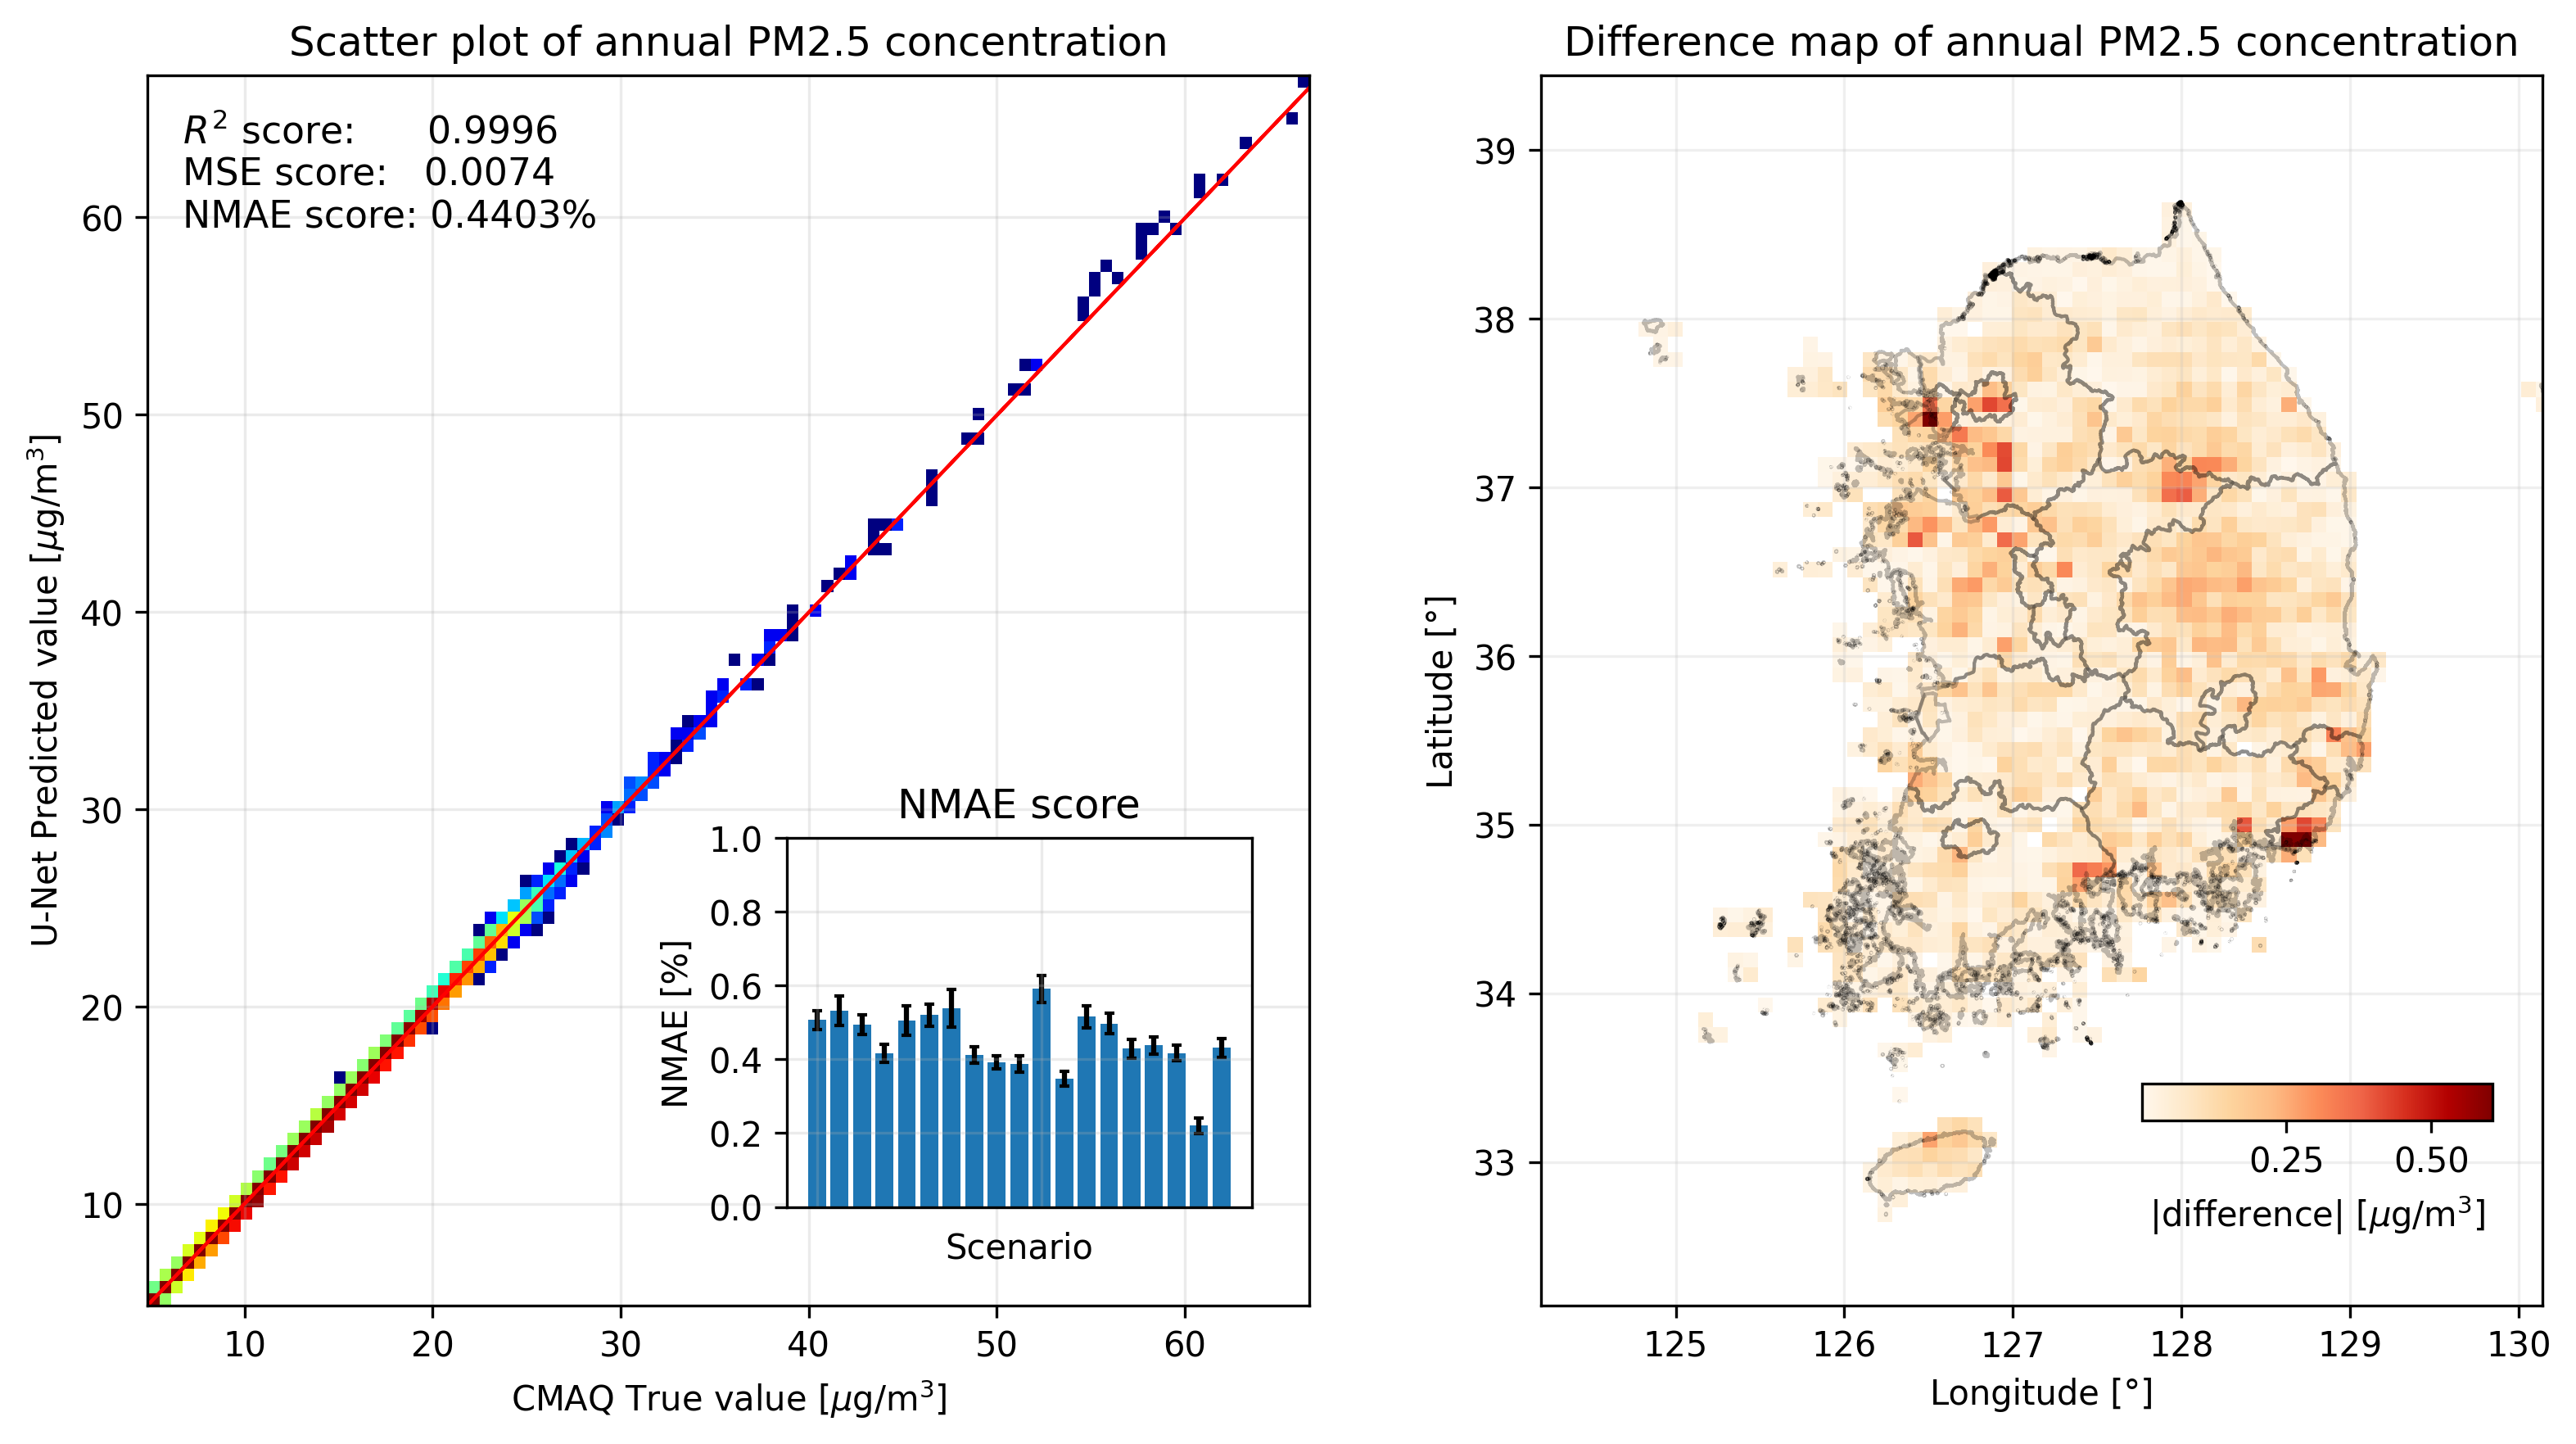

In [89]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=100, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}",
        linewidth=1)
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    nmae = nmae_score(y_true, y_pred)*100
    # add text
    ax.text(
        0.03, 0.97, f"$R^2$ score:      {r2:.4f}\nMSE score:   {rmse:.4f}\nNMAE score: {nmae:.4f}%",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

ctprvn = get_ctprvn_map()
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
ctprvn_proj = ctprvn.to_crs(proj)

grid_alloc = pd.read_csv('/workdir/datasets/grid_allocation.csv')
grid_alloc = grid_alloc.sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False])
grid_alloc = grid_alloc.drop_duplicates(subset=['Row', 'Column'], keep='first').reset_index(drop=True)

pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], REGION_CODE[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1
row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)

offset_x, offset_y = 4500, 4500
mask = np.zeros((82, 67, 1))
mask[row_indices, col_indices] = 1
cmap_white = mpl.colormaps['OrRd']
cmap_white.set_under('white')

fig, axes = plt.subplots(1, 2, figsize=(13, 6.5), dpi=300)

y_true = conc_test.reshape(-1)
y_pred = conc_yearly_unet_pred.reshape(-1)
axes[0] = plot_scatter(axes[0], y_true, y_pred)
axes[0].grid(alpha=0.25)
axes[0].set_title(f"Scatter plot of annual PM2.5 concentration")
axes[0].set_xlabel("CMAQ True value [$\mu \mathrm{g}/\mathrm{m}^3$]")
axes[0].set_ylabel("U-Net Predicted value [$\mu \mathrm{g}/\mathrm{m}^3$]")

cbaxes = axes[0].inset_axes([0.55, 0.08, 0.4, 0.3])
y_true = conc_test.reshape(19, -1)
y_pred = conc_yearly_unet_pred.reshape(19, -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

cbaxes.bar(np.arange(19), score*100, yerr=score_std*100, label=label_text, capsize=1.5, zorder=1)
cbaxes.set_xticklabels(['' for _ in range(19)])
cbaxes.tick_params(axis='x', which='both', bottom=False)
cbaxes.set_ylim(0.0, 1.0)
cbaxes.set_title(f"NMAE score")
cbaxes.set_xlabel('Scenario', labelpad=0)
cbaxes.set_ylabel('NMAE [%]')
cbaxes.grid(alpha=0.25, zorder=99)

sc = 11
diff_map = np.abs(conc_test[sc] - conc_yearly_unet_pred[sc])
new_map = np.where(mask==1, diff_map, 0)[::-1]
axes[1].imshow(new_map, cmap=cmap_white, extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y), vmin=0.001)
cbaxes = axes[1].inset_axes([0.6, 0.15, 0.35, 0.03])
cb = plt.colorbar(axes[1].images[0], cax=cbaxes, orientation='horizontal', label='PM2.5 ($\mu g/m^3$)')
cb.set_label(label='|difference| [$\mu \mathrm{g}/\mathrm{m}^3$]')

axes[1] = ctprvn_proj.boundary.plot(ax=axes[1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
axes[1].set_xlim(-180000, 414000)
axes[1].set_ylim(-585000, 144000)
axes[1].set_title(f'Difference map of annual PM2.5 concentration')
axes[1].set_xlabel('Longitude [°]')
axes[1].set_ylabel('Latitude [°]')
axes[1].grid(alpha=0.25, color='silver')
axes[1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
axes[1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])

plt.subplots_adjust(wspace=0.13)
plt.show()

In [30]:
conc_yearly_unet_model.save('/workdir/paper/models/conc_unet_model_yearly/just_unet')

INFO:tensorflow:Assets written to: /workdir/paper/models/conc_unet_model_yearly/just_unet/assets


INFO:tensorflow:Assets written to: /workdir/paper/models/conc_unet_model_yearly/just_unet/assets


In [ ]:
emis_conc_yearly_unet_model = get_unet_model(input_shape=(82, 67, 6))

In [33]:
emis_conc_yearly_unet_model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
)
history = emis_conc_yearly_unet_model.fit(
    emis_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1
)

Epoch 1/1000
3/3 [==============================] - 11s 717ms/step - loss: 153.5380 - val_loss: 15989918.0000
Epoch 2/1000
3/3 [==============================] - 0s 135ms/step - loss: 144.6562 - val_loss: 10050572648448.0000
Epoch 3/1000
3/3 [==============================] - 0s 133ms/step - loss: 140.2632 - val_loss: 169425118429184.0000
Epoch 4/1000
3/3 [==============================] - 0s 142ms/step - loss: 137.9586 - val_loss: 218246649217024.0000
Epoch 5/1000
3/3 [==============================] - 0s 133ms/step - loss: 136.1863 - val_loss: 58006813278208.0000
Epoch 6/1000
3/3 [==============================] - 0s 139ms/step - loss: 134.8476 - val_loss: 11194972766208.0000
Epoch 7/1000
3/3 [==============================] - 0s 134ms/step - loss: 133.5434 - val_loss: 1897477308416.0000
Epoch 8/1000
3/3 [==============================] - 0s 143ms/step - loss: 132.5264 - val_loss: 217331761152.0000
Epoch 9/1000
3/3 [==============================] - 0s 143ms/step - loss: 131.4767 - v

In [34]:
emis_conc_yearly_unet_model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
)
history = emis_conc_yearly_unet_model.fit(
    emis_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1
)

Epoch 1/1000
3/3 [==============================] - 9s 475ms/step - loss: 0.0299 - val_loss: 0.0581
Epoch 2/1000
3/3 [==============================] - 0s 134ms/step - loss: 0.0210 - val_loss: 0.0777
Epoch 3/1000
3/3 [==============================] - 0s 132ms/step - loss: 0.0107 - val_loss: 0.0466
Epoch 4/1000
3/3 [==============================] - 0s 134ms/step - loss: 0.0138 - val_loss: 0.0533
Epoch 5/1000
3/3 [==============================] - 0s 132ms/step - loss: 0.0081 - val_loss: 0.0575
Epoch 6/1000
3/3 [==============================] - 0s 139ms/step - loss: 0.0078 - val_loss: 0.0388
Epoch 7/1000
3/3 [==============================] - 0s 133ms/step - loss: 0.0066 - val_loss: 0.0394
Epoch 8/1000
3/3 [==============================] - 0s 136ms/step - loss: 0.0063 - val_loss: 0.0436
Epoch 9/1000
3/3 [==============================] - 0s 131ms/step - loss: 0.0055 - val_loss: 0.0389
Epoch 10/1000
3/3 [==============================] - 0s 132ms/step - loss: 0.0099 - val_loss: 0.0291

In [35]:
emis_conc_yearly_unet_model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-5),
    loss=tf.keras.losses.MeanSquaredError(),
)
history = emis_conc_yearly_unet_model.fit(
    emis_train, conc_train,
    validation_split=0.1, batch_size=32, epochs=1000, verbose=1
)

Epoch 1/1000
3/3 [==============================] - 11s 342ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 2/1000
3/3 [==============================] - 0s 132ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 3/1000
3/3 [==============================] - 0s 133ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 4/1000
3/3 [==============================] - 0s 155ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 5/1000
3/3 [==============================] - 0s 131ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 6/1000
3/3 [==============================] - 0s 135ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 7/1000
3/3 [==============================] - 0s 132ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 8/1000
3/3 [==============================] - 0s 144ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 9/1000
3/3 [==============================] - 0s 132ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 10/1000
3/3 [==============================] - 0s 160ms/step - loss: 0.0026 - val_loss: 0.003

In [36]:
emis_conc_yearly_unet_pred = emis_conc_yearly_unet_model.predict(emis_test)

1/1 [==============================] - 0s 430ms/step


In [39]:
emis_conc_yearly_unet_model.save('/workdir/paper/models/conc_unet_model_yearly/unet')

INFO:tensorflow:Assets written to: /workdir/paper/models/conc_unet_model_yearly/unet/assets


INFO:tensorflow:Assets written to: /workdir/paper/models/conc_unet_model_yearly/unet/assets


In [40]:
row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)

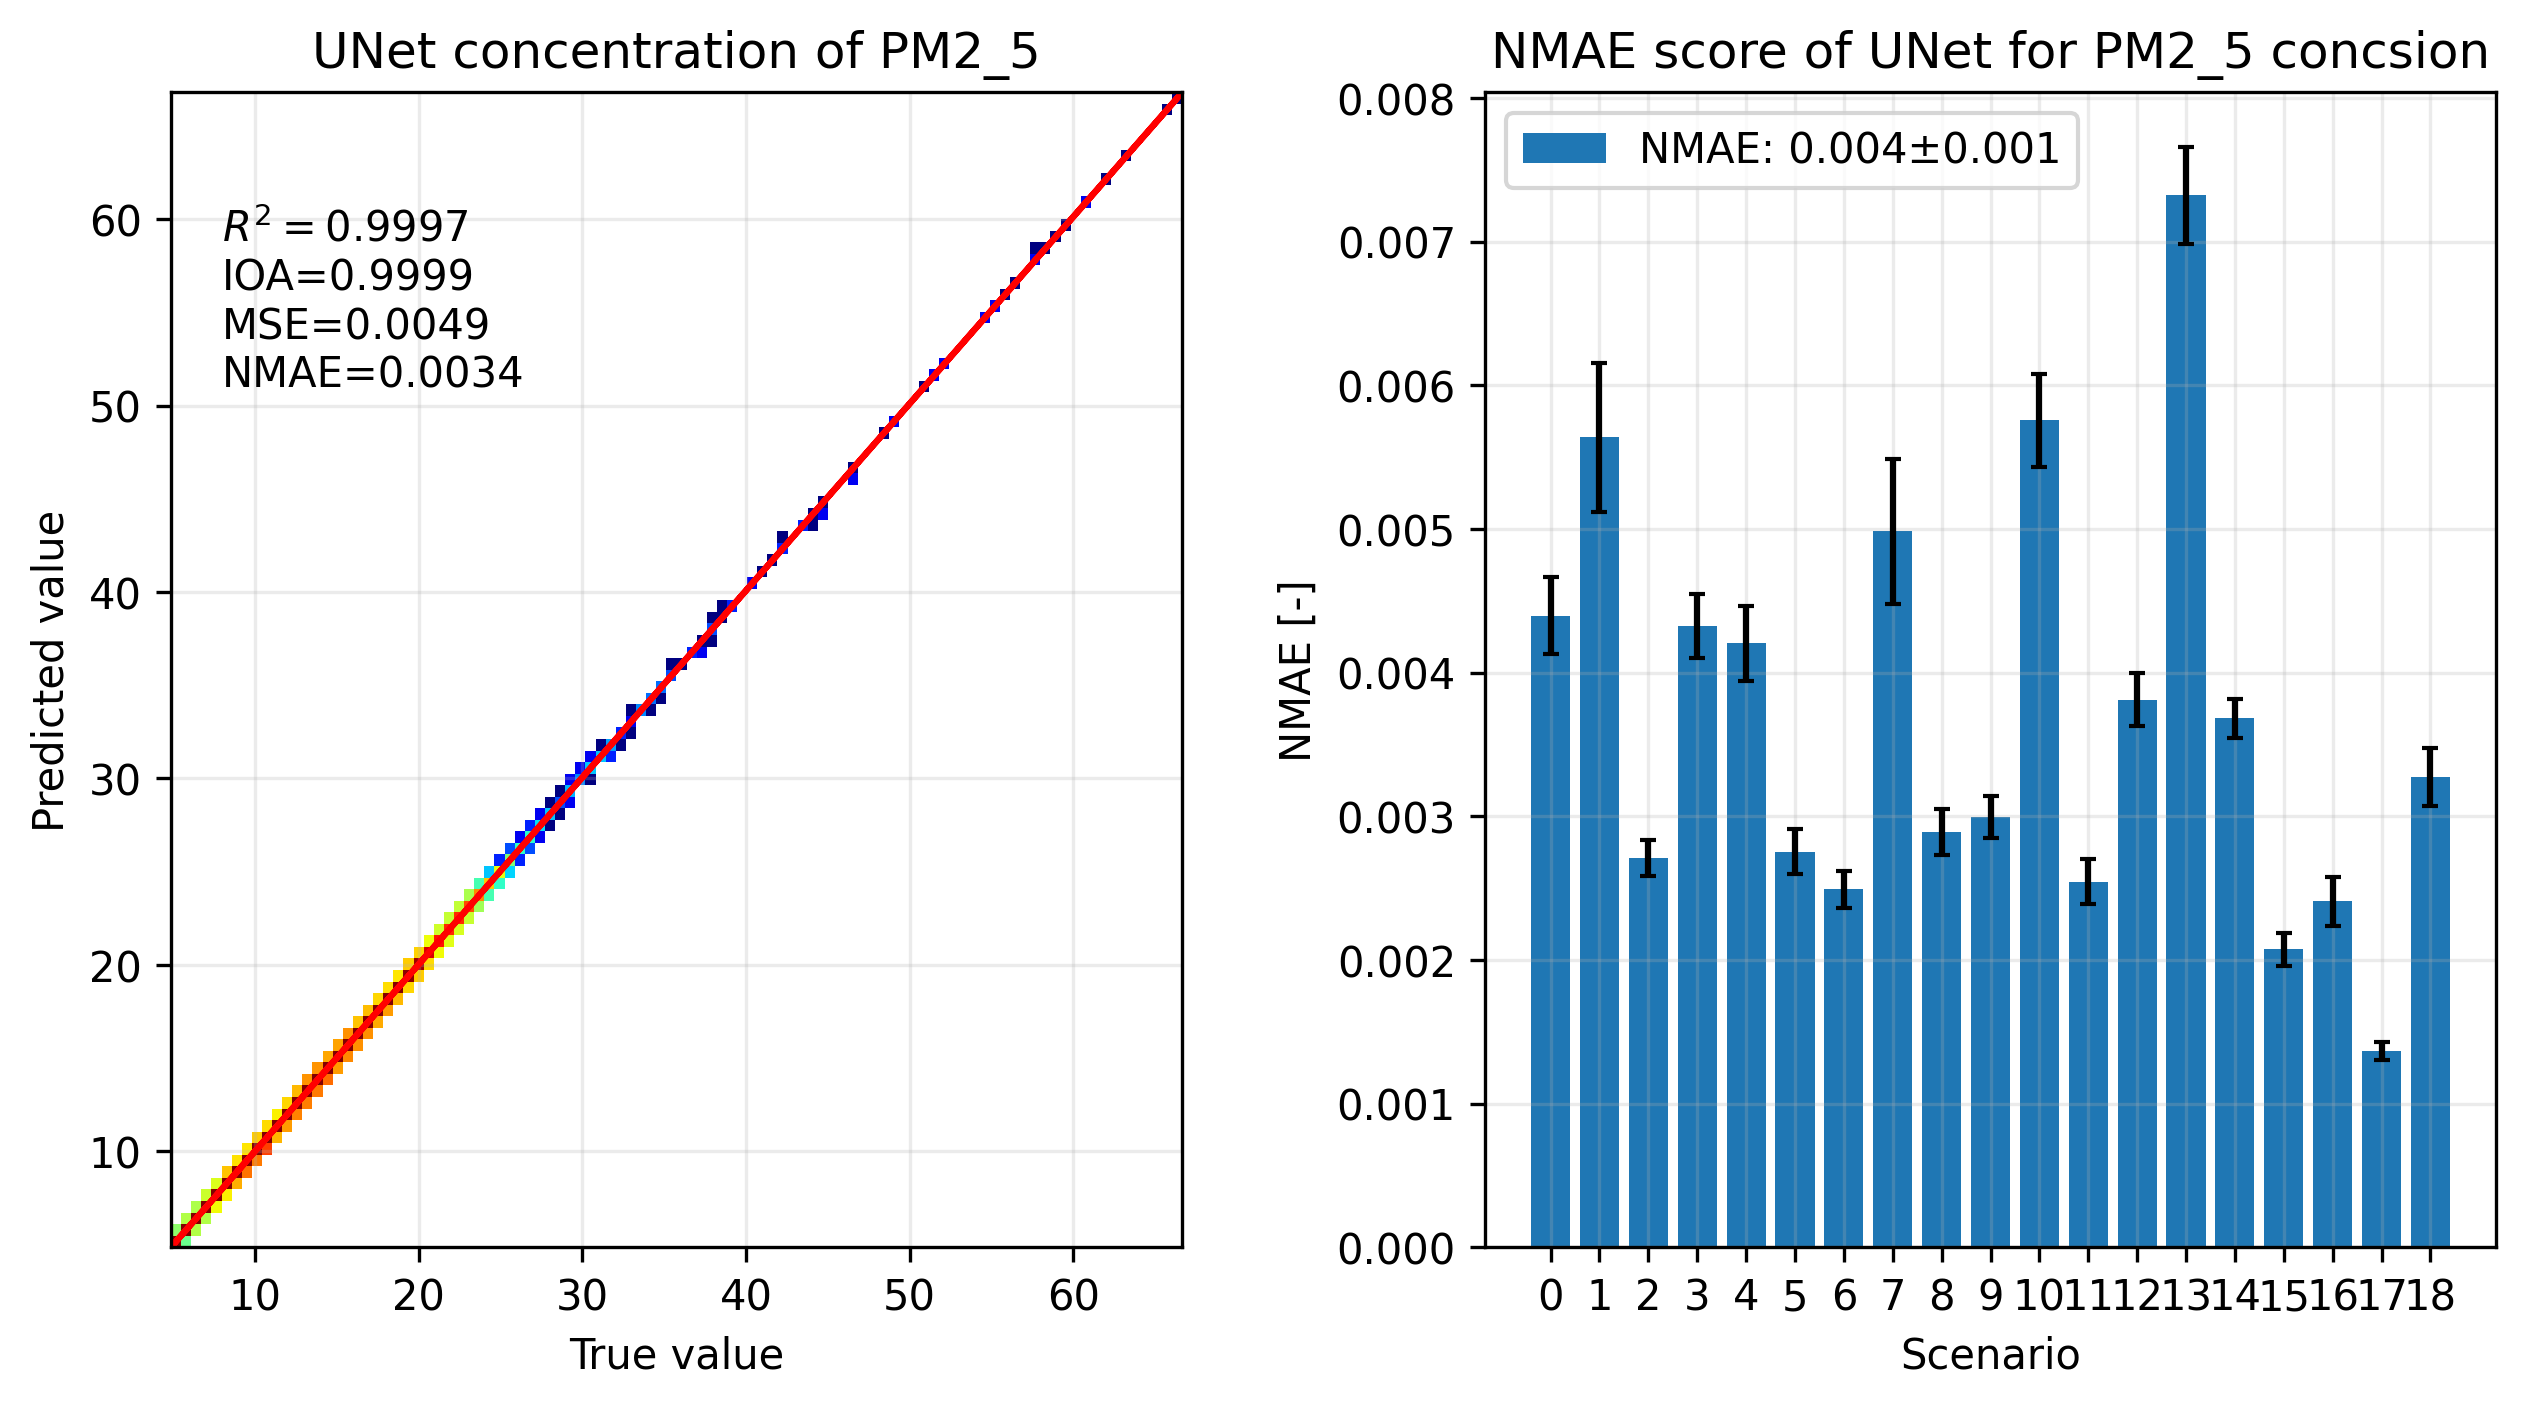

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

y_true = conc_test.reshape(-1)
y_pred = emis_conc_yearly_unet_pred.reshape(-1)
axes[0] = plot_scatter(axes[0], y_true, y_pred)
axes[0].grid(alpha=0.25)
axes[0].set_title(f"UNet concentration of {CONC_KEY_LIST[0]}")
axes[0].set_xlabel("True value")
axes[0].set_ylabel("Predicted value")

y_true = conc_test.reshape(19, -1)
y_pred = emis_conc_yearly_unet_pred.reshape(19, -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'
axes[1].bar(np.arange(19), score, yerr=score_std, label=label_text, capsize=2)
axes[1].set_xticks(np.arange(19), range(19))
axes[1].legend()
axes[1].grid(alpha=0.25)
axes[1].set_title(f"NMAE score of UNet for {CONC_KEY_LIST[0]} concsion")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [-]')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [41]:
class CMAQPipeline(object):
    def __init__(self, emis_models, conc_model, row, col):
        self.emis_models = emis_models
        self.conc_model = conc_model
        self.row = row
        self.col = col
    
    def predict(self, X):
        batch_size = X.shape[0]
        emis_preds = np.concatenate([
            emis_model.predict(X).reshape(-1, 1592, 1)/weights[i]
            for i, emis_model in enumerate(self.emis_models.values())
        ], axis=2)
        emis_preds_map = np.zeros((batch_size, 82, 67, 6))
        emis_preds_map[:, self.row, self.col, :] = emis_preds
        conc_preds = self.conc_model.predict(emis_preds_map, verbose=0)
        return conc_preds

cmaq_yearly_lasso_unet_model = CMAQPipeline(
    emis_yearly_lasso_model,
    conc_yearly_unet_model,
    row_indices, col_indices)
cmaq_yearly_xgb_unet_model = CMAQPipeline(
    emis_yearly_xgb_model,
    conc_yearly_unet_model,
    row_indices, col_indices)

cmaq_yearly_lasso_unet_pred = cmaq_yearly_lasso_unet_model.predict(ctrl_test)
cmaq_yearly_xgb_unet_pred = cmaq_yearly_xgb_unet_model.predict(ctrl_test)

NameError: name 'emis_yearly_lasso_model' is not defined

#### Evaluate

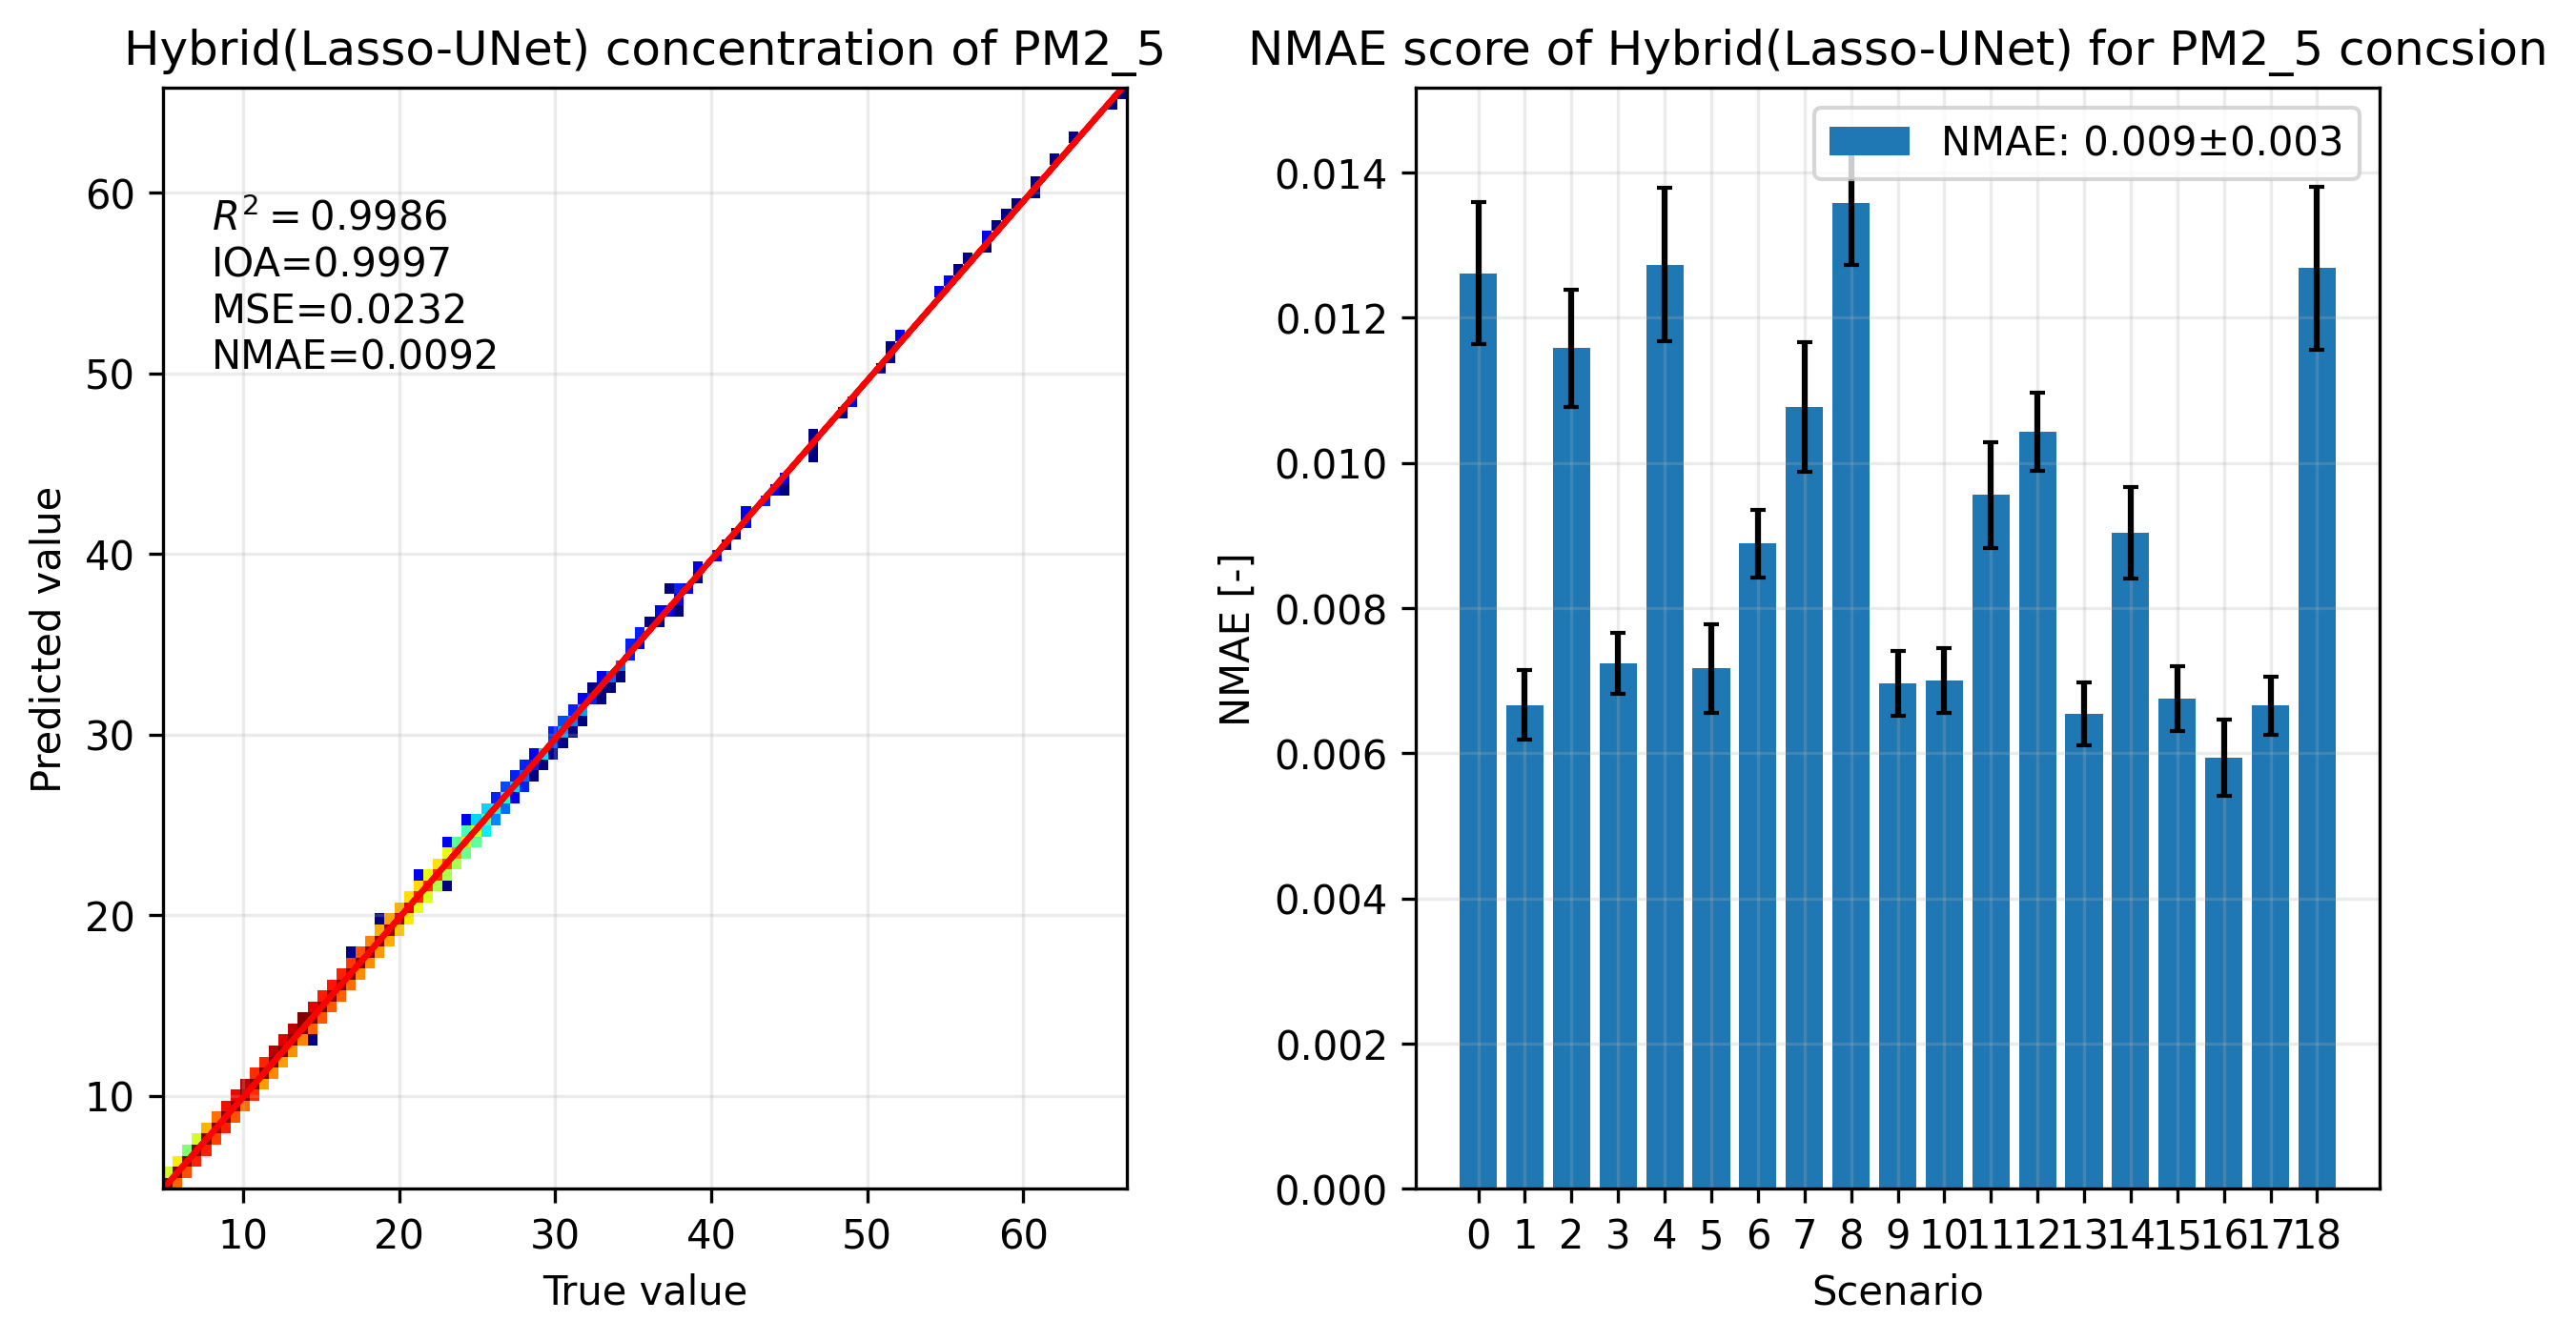

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

y_true = conc_test.reshape(-1)
y_pred = cmaq_yearly_lasso_unet_pred.reshape(-1)
axes[0] = plot_scatter(axes[0], y_true, y_pred)
axes[0].grid(alpha=0.25)
axes[0].set_title(f"Hybrid(Lasso-UNet) concentration of {CONC_KEY_LIST[0]}")
axes[0].set_xlabel("True value")
axes[0].set_ylabel("Predicted value")

y_true = conc_test.reshape(19, -1)
y_pred = cmaq_yearly_lasso_unet_pred.reshape(19, -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'
axes[1].bar(np.arange(19), score, yerr=score_std, label=label_text, capsize=2)
axes[1].set_xticks(np.arange(19), range(19))
axes[1].legend()
axes[1].grid(alpha=0.25)
axes[1].set_title(f"NMAE score of Hybrid(Lasso-UNet) for {CONC_KEY_LIST[0]} concsion")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [-]')

plt.subplots_adjust(wspace=0.3)
plt.show()

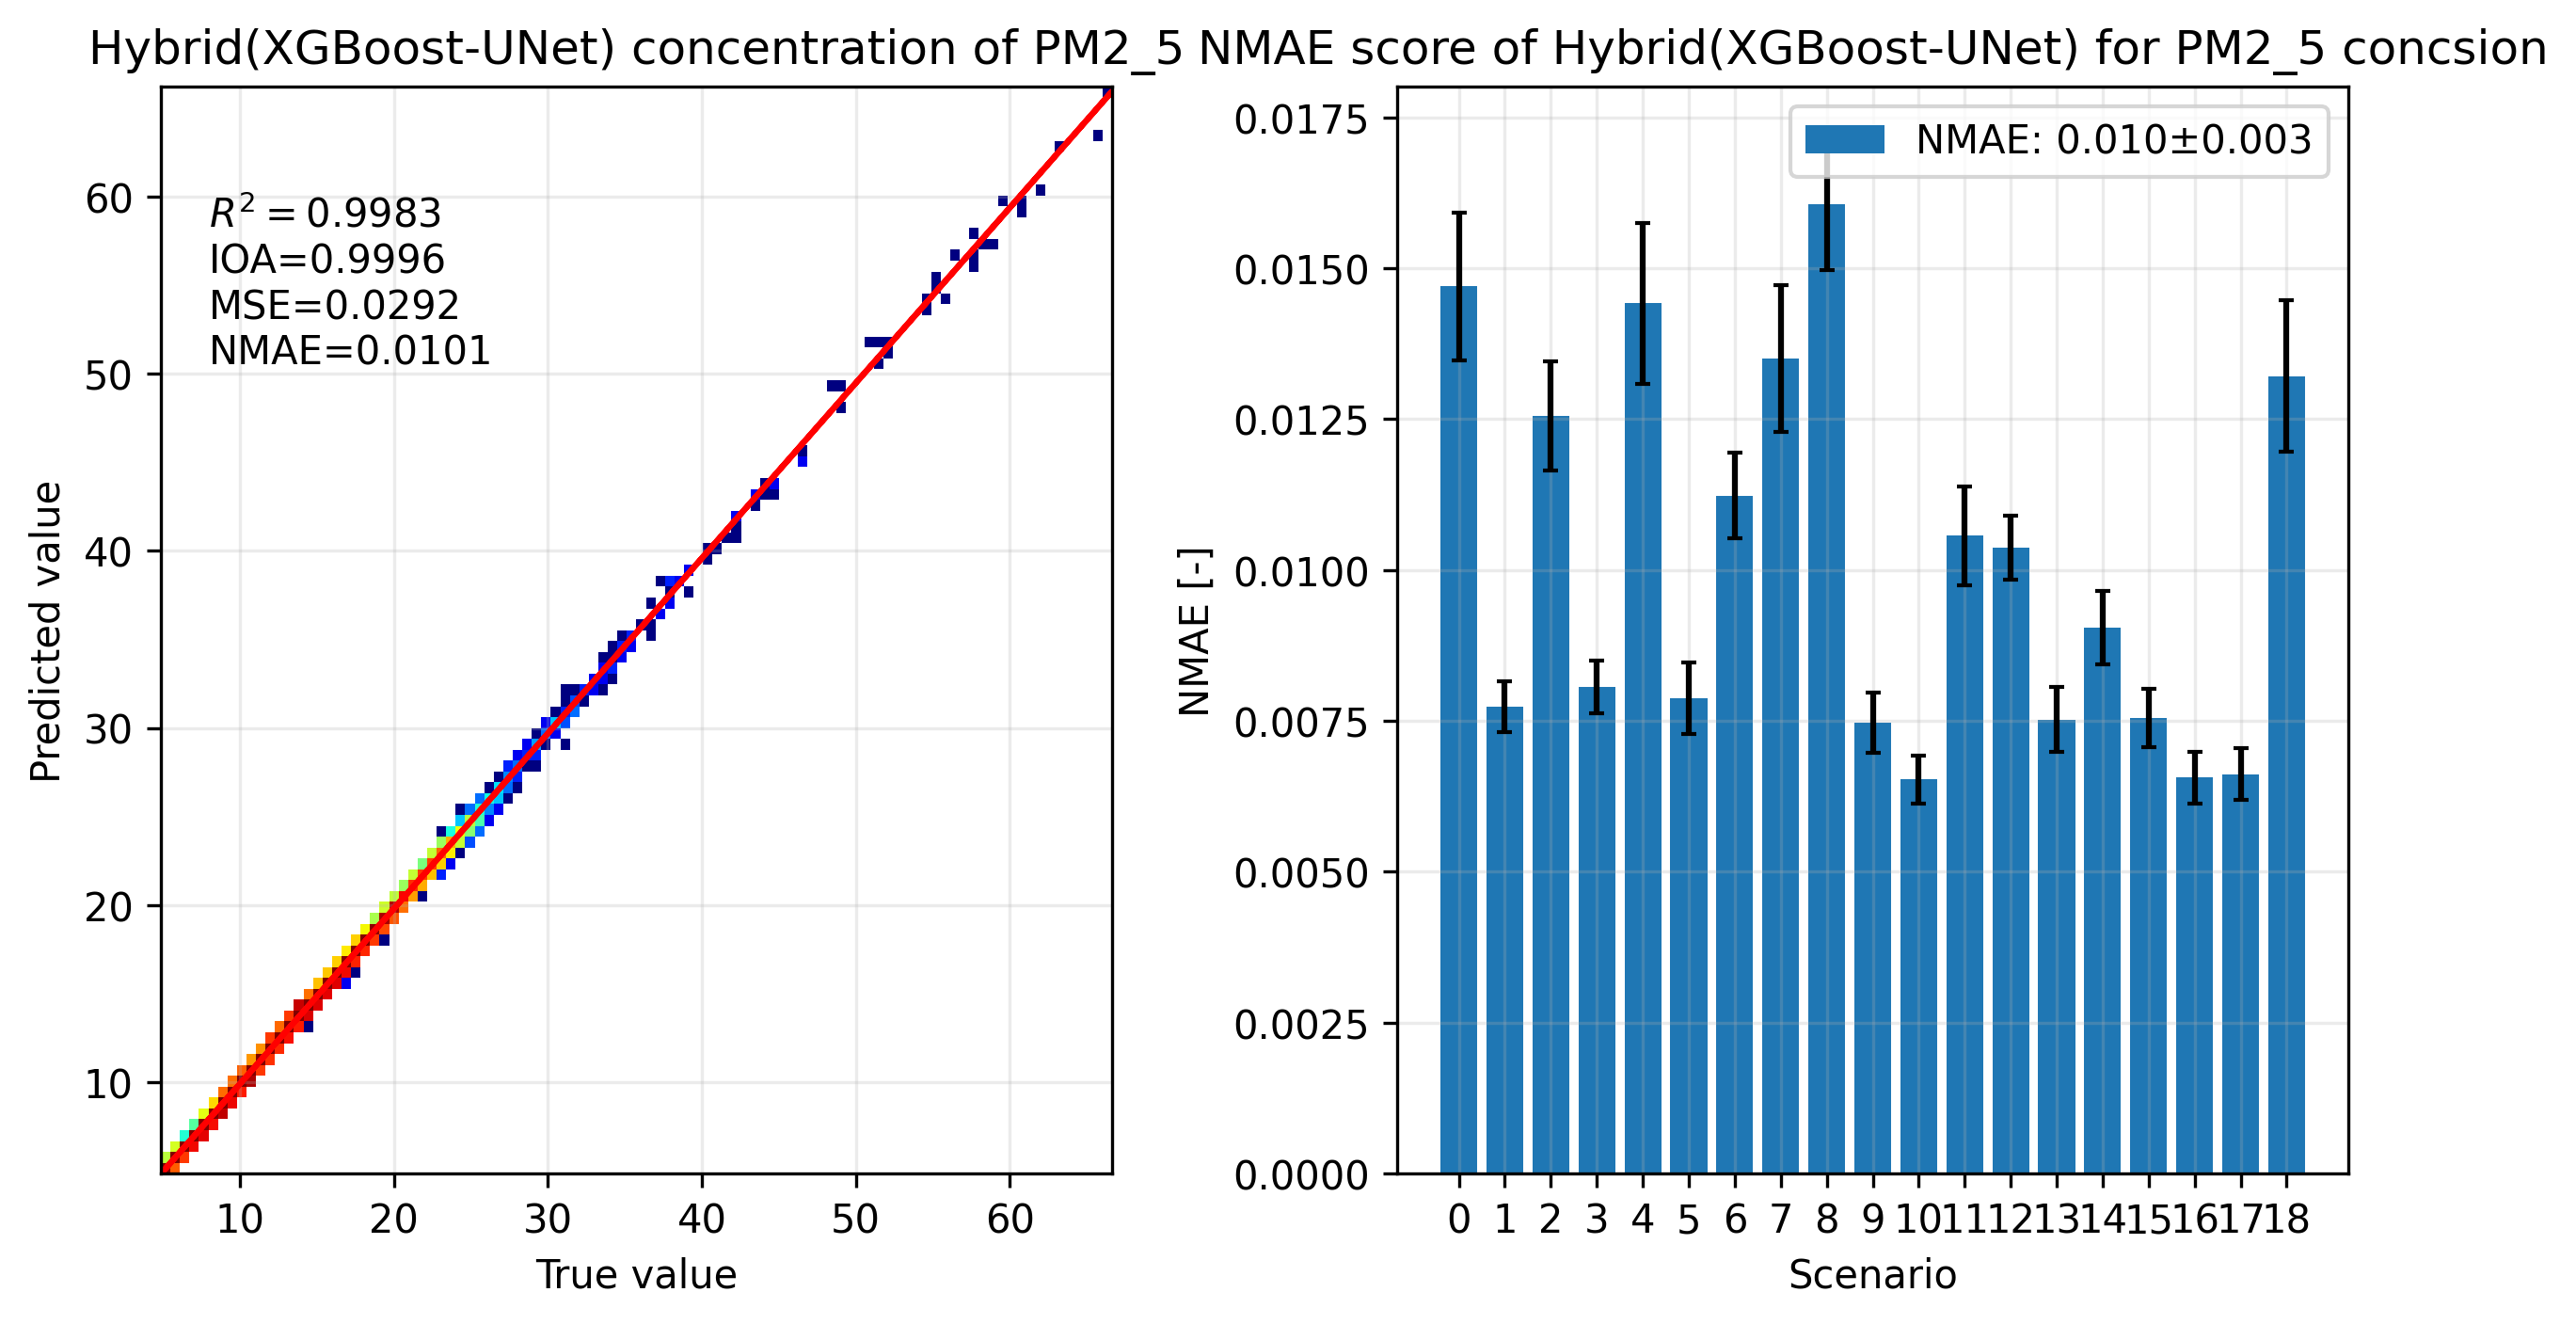

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

y_true = conc_test.reshape(-1)
y_pred = cmaq_yearly_xgb_unet_pred.reshape(-1)
axes[0] = plot_scatter(axes[0], y_true, y_pred)
axes[0].grid(alpha=0.25)
axes[0].set_title(f"Hybrid(XGBoost-UNet) concentration of {CONC_KEY_LIST[0]}")
axes[0].set_xlabel("True value")
axes[0].set_ylabel("Predicted value")

y_true = conc_test.reshape(19, -1)
y_pred = cmaq_yearly_xgb_unet_pred.reshape(19, -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'
axes[1].bar(np.arange(19), score, yerr=score_std, label=label_text, capsize=2)
axes[1].set_xticks(np.arange(19), range(19))
axes[1].legend()
axes[1].grid(alpha=0.25)
axes[1].set_title(f"NMAE score of Hybrid(XGBoost-UNet) for {CONC_KEY_LIST[0]} concsion")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [-]')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [ ]:
x = np.arange(0, 2.001, 0.001)

continuous_sample = np.array([[i for _ in range(119)] for i in x])
def get_ctrl_map(X):
    X = X.reshape(-1, 17, 7)
    ctrl_map = np.zeros((X.shape[0], 82, 67, 7))
    for i, key in enumerate(REGION_CODE.keys()):
        index = grid_alloc.loc[grid_alloc.Region_Code==key, ['Row', 'Column']]
        index = index.drop_duplicates().values - 1
        row, col = zip(*index)
        ctrl_map[:, row, col, :] = X[:, i:i+1, :]
    return ctrl_map

cmaq_yearly_lasso_unet_contiuous = conc_yearly_unet_model.predict(get_ctrl_map(continuous_sample)).mean(axis=(1, 2, 3))
# cmaq_yearly_xgb_unet_contiuous = cmaq_yearly_xgb_unet_model.predict(continuous_sample).mean(axis=(1, 2, 3))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

axes[0].plot(x, cmaq_yearly_lasso_unet_contiuous)
axes[0].set_title(f"Hybrid(Lasso-UNet) concentration of {CONC_KEY_LIST[0]}")
axes[0].set_xlabel("Control parameter")
axes[0].set_ylabel("Concentration rate")

# axes[1].plot(x, cmaq_yearly_xgb_unet_contiuous)
# axes[1].set_title(f"Hybrid(XGBoost-UNet) concentration of {CONC_KEY_LIST[0]}")
# axes[1].set_xlabel("Control parameter")
# axes[1].set_ylabel("Concentration rate")

plt.show()

In [3]:
from cmaqnet.alloc import allocation, const_allocation
from cmaqnet.model import get_unet_model
REGION_CODE = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'
}

def read_cdf_map_data(
        data_path:str,
        target:str,
        prefix:str,
        keys:list[str]) -> np.ndarray:
    paths = [os.path.join(f'{data_path}/{target}/', f'{prefix}.{i+1}') for i in range(119)]
    datasets = [[nc.Dataset(path, 'r')[key][0, 0].data.tolist() for key in keys] for path in paths]
    return np.transpose(datasets, (0, 2, 3, 1))

alloc_df = pd.DataFrame(allocation, columns=['Region_Name', 'Region_Code', 'Row', 'Column', 'Ratio'])
const_alloc_df = pd.DataFrame(const_allocation, columns=['Region_Name', 'Region_Code', 'Row', 'Column', 'Ratio'])

In [4]:
ctrl = pd.read_csv('/workdir/datasets/control_matrix.csv', index_col=0)
ctrl = ctrl.values.reshape(-1, 17, 7)
ctrl_map = np.zeros((119, 82, 67, 7))
for i, key in enumerate(list(REGION_CODE.keys())):
    value = ctrl[:, i:i+1, :]
    index = const_alloc_df.loc[const_alloc_df['Region_Code']==key, ['Row', 'Column']].values
    row, col = zip(*index)
    ctrl_map[:, row, col, :] = value

ctrl = pd.read_csv('/workdir/datasets/control_matrix.csv', index_col=0)
ctrl = ctrl.values.reshape(-1, 17, 7)
ctrl_mapv = np.zeros((119, 82, 67, 7))
for i, key in enumerate(list(REGION_CODE.keys())):
    value = ctrl[:, i:i+1, :]
    index = alloc_df.loc[alloc_df['Region_Code']==key, ['Row', 'Column']].values
    ratio = alloc_df.loc[alloc_df['Region_Code']==key, ['Ratio']].values / 100
    ratio = ratio.reshape(1, -1, 1)
    value = value * ratio
    row, col = zip(*index)
    ctrl_mapv[:, row, col, :] += value

In [15]:
models = [
    (tf.keras.models.load_model(f'/workdir/models/conc_pm25_unet_{i}.h5'), tf.keras.models.load_model(f'/workdir/models/conc_pm25_unet_{i}_30.h5'))
    for i in range(4)
]

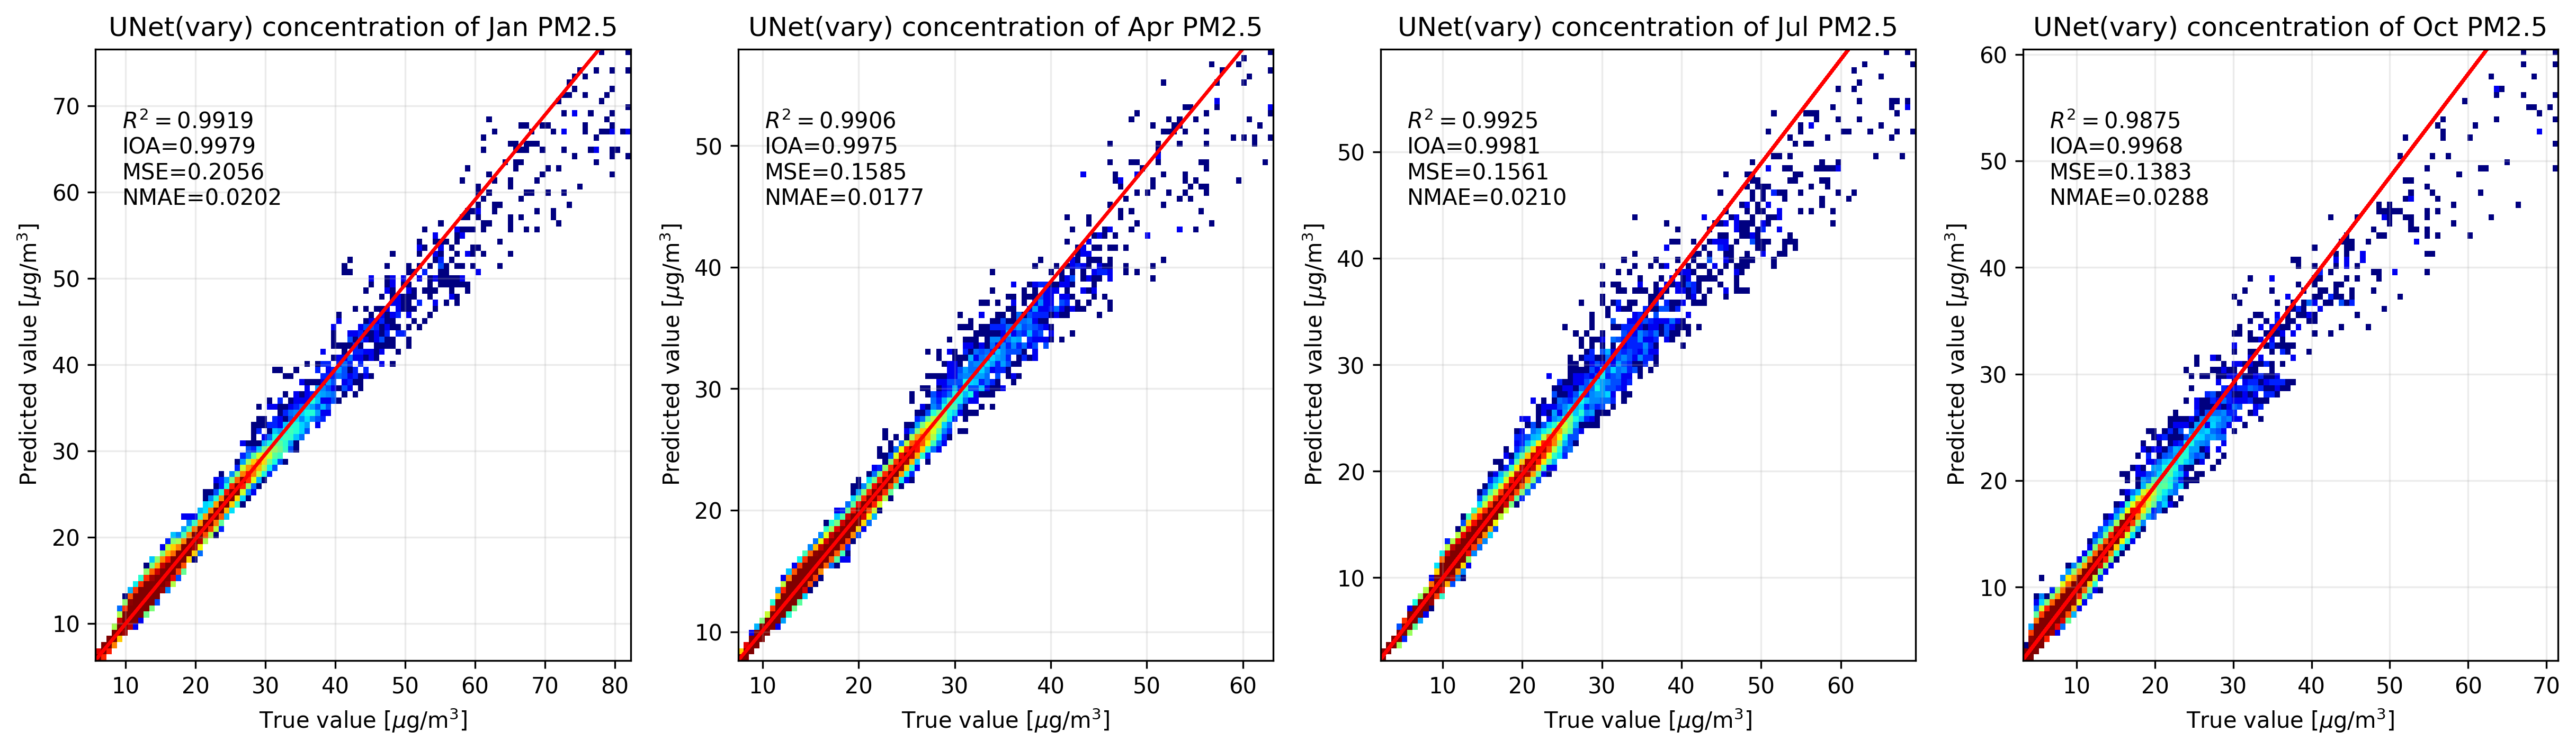

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=300)

season = ['Jan', 'Apr', 'Jul', 'Oct']
for i in range(4):
    conc = np.load(f'/workdir/datasets/conc_pm_map_{i}.npy')[:, -1, :, :, np.newaxis]
    _, ctrl_test, _, conc_test = train_test_split(ctrl_mapv, conc, train_size=10, random_state=42)
    conc_pred = models[i][1].predict(ctrl_test, verbose=0)
    y_true = conc_test.reshape(-1)
    y_pred = conc_pred.reshape(-1)
    axes[i] = plot_scatter(axes[i], y_true, y_pred)
    axes[i].grid(alpha=0.25)
    axes[i].set_title(f"UNet(vary) concentration of {season[i]} PM2.5")
    axes[i].set_xlabel("True value $[\mu \mathrm{g}/\mathrm{m}^3]$")
    axes[i].set_ylabel("Predicted value $[\mu \mathrm{g}/\mathrm{m}^3]$")

plt.show()

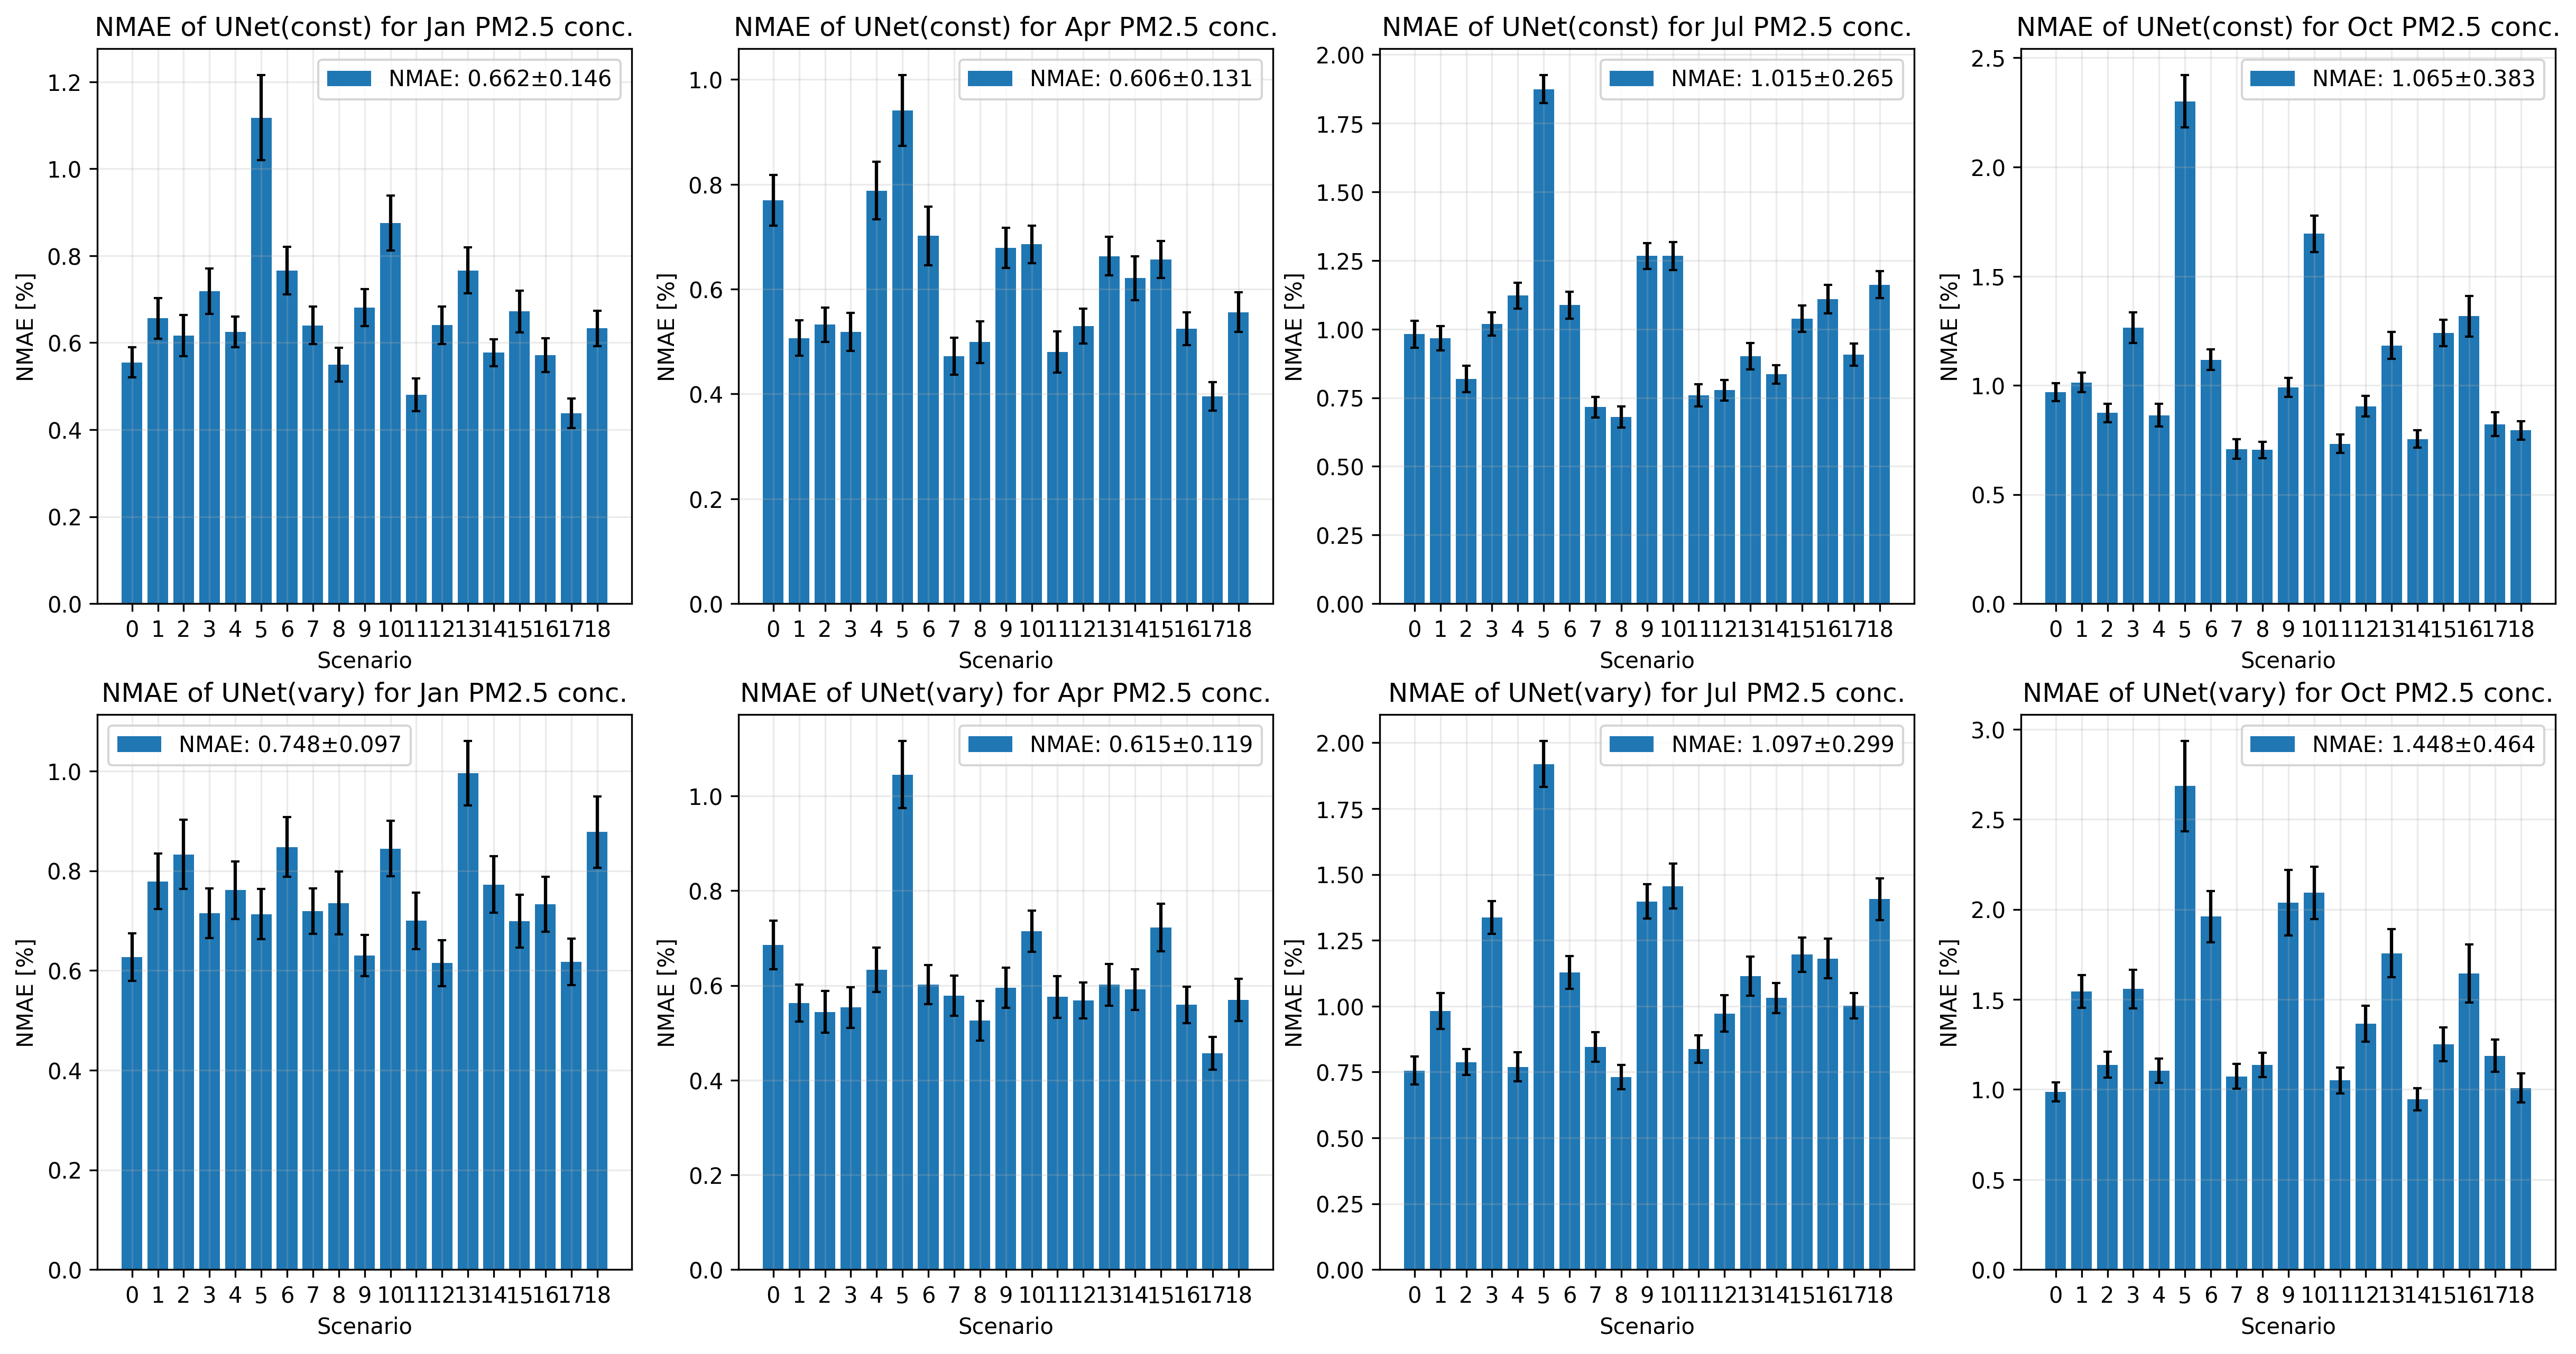

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), dpi=300)

season = ['Jan', 'Apr', 'Jul', 'Oct']
for i in range(4):
    conc = np.load(f'/workdir/datasets/conc_pm_map_{i}.npy')[:, -1, :, :, np.newaxis]
    _, ctrl_test, _, conc_test = train_test_split(ctrl_map, conc, train_size=100, random_state=42)
    conc_pred = models[i][0].predict(ctrl_test, verbose=0)
    y_true = conc_test.reshape(19, -1)
    y_pred = conc_pred.reshape(19, -1)
    score, score_std = get_score(y_true, y_pred)
    label_text = f'NMAE: {np.mean(score)*100:.3f}±{np.std(score)*100:.3f}'
    axes[0][i].bar(np.arange(19), score*100, yerr=score_std*100, label=label_text, capsize=2)
    axes[0][i].set_xticks(np.arange(19), range(19))
    axes[0][i].legend()
    axes[0][i].grid(alpha=0.25)
    axes[0][i].set_title(f"NMAE of UNet(const) for {season[i]} PM2.5 conc.")
    axes[0][i].set_xlabel('Scenario')
    axes[0][i].set_ylabel('NMAE [%]')

    _, ctrl_test, _, conc_test = train_test_split(ctrl_mapv, conc, train_size=100, random_state=42)
    conc_pred = models[i][1].predict(ctrl_test, verbose=0)
    y_true = conc_test.reshape(19, -1)
    y_pred = conc_pred.reshape(19, -1)
    score, score_std = get_score(y_true, y_pred)
    label_text = f'NMAE: {np.mean(score)*100:.3f}±{np.std(score)*100:.3f}'
    axes[1][i].bar(np.arange(19), score*100, yerr=score_std*100, label=label_text, capsize=2)
    axes[1][i].set_xticks(np.arange(19), range(19))
    axes[1][i].legend()
    axes[1][i].grid(alpha=0.25)
    axes[1][i].set_title(f"NMAE of UNet(vary) for {season[i]} PM2.5 conc.")
    axes[1][i].set_xlabel('Scenario')
    axes[1][i].set_ylabel('NMAE [%]')

plt.show()